# Assignement 2: Learning to Rank <a class="anchor" id="toptop"></a>

**Learning Goals**:
- Part 1: Offline LTR
  - Learn how to implement pointwise, pairwise and listwise algorithms for learning to rank 
- Part 2: Online LTR
  - Implement learning to rank algorithms from historical clicks and online evaluation of ranking algorithms.
- Learn their weaknesses & strengths and when each method is suitable. 



**Files to submit along with the completed notebook**:
- `pointwise_regression.json`
- `pointwise_classification.json`
- `pairwise.json`
- `listwise.json`
- `biased_model.json'
- `unbiased_model.json'

# Table of Contents  <a class="anchor" id="top"></a>

[Back to top](#toptop)


Table of contents:


 - [Chapter 1: Offline LTR](#o_LTR) (345 points)
     - [Section 1: Dataset and Utility](#dataU) 
     - [Section 2: Pointwtise LTR](#pointwiseLTR) (55 points)
     - [Section 3: Pairwise LTR](#pairwiseLTR) (60 points)
     - [Section 4: Pairwise Speed-up RankNet](#SpairwiseLTR) (70 points)
     - [Section 5: Listwise LTR](#listwiseLTR) (80 points)
     - [Section 6: Evaluation](#evaluation1) (70 points)
 - [Chapter 2: Online LTR](#onLTR) (180 points)
     - [Section 1: Clicks Simulation](#clicks) (15 points)
     - [Section 2: Counterfactual](#cLTR) (90 points)
     - [Section 3: Online Evaluation](#on_eval) (75 points)

In [1]:
import os
import json
import itertools
from argparse import Namespace
from collections import OrderedDict
from functools import partial


import torch
import numpy as np
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd

import dataset
import evaluate


# Chapter 1: Offline LTR <a class="anchor" id="o_LTR"></a>

A typical setup of learning to rank involves a feature vector constructed using a query-document pair, and a set of relevance judgements. You are given a set of triples (`query`, `document`, `relevance grade`); where relevance grade is an *ordinal* variable  with  5  grades,  for example: {`perfect`,`excellent`,`good`,`fair`,`bad`),  typically  labeled  by human annotators.  

In this assignment, you are already given the feature vector for a given document and query pair. To access these vectors, see the following code cells (note: the dataset will be automatically downloaded & the first time the next cell runs, it will take a while!)

## Section 1: Data and Utility <a class="anchor" id="dataU"></a>

[Back to TOC](#top)

First let's get familiar with the dataset and some utility methods for our implementations.

### Section 1.1 Dataset stats

| Split Name | \# queries | \# docs | \# features |
| :- | :--: | :--: | :--: |
| train | 2735 | 85227 | 501 |
| validation | 403 | 12794 | 501 |
| test | 949 | 29881 | 501 |


In [2]:
dataset.download_dataset()
data = dataset.get_dataset()
# there is only 1 fold for this dataset 
data = data.get_data_folds()[0]
# read in the data
data.read_data()

In [3]:
print(f"Number of features: {data.num_features}")
# print some statistics
for split in ["train", "validation", "test"]:
    print(f"Split: {split}")
    split = getattr(data, split)
    print(f"\tNumber of queries {split.num_queries()}")
    print(f"\tNumber of docs {split.num_docs()}")

Number of features: 501
Split: train
	Number of queries 2735
	Number of docs 85227
Split: validation
	Number of queries 403
	Number of docs 12794
Split: test
	Number of queries 949
	Number of docs 29881


### Section 1.2 Utility classes/methods

The following cells contain code that will be useful for the assigment. 

In [4]:
# these is a useful class to create torch DataLoaders, and can be used during training
class LTRData(Dataset):
    def __init__(self, data, split):
        split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert split is not None, "Invalid split!"
        features, labels = split.feature_matrix, split.label_vector
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, i):
        return self.features[i], self.labels[i]

In [5]:
## example 
train_dl = DataLoader(LTRData(data, "train"), batch_size=32, shuffle=True)
# this is how you would use it to quickly iterate over the train/val/test sets 
# - (of course, without the break statement!)
for (x, y) in train_dl:
    print(x.size(), y.size())
    break

torch.Size([32, 501]) torch.Size([32])


`evaluate_model` evaluates a model, on a given split.

In [6]:
# this function evaluates a model, on a given split
def evaluate_model(pred_fn, split, batch_size=256, print_results=False, q_level=False):
    dl = DataLoader(LTRData(data, split), batch_size=batch_size)
    all_scores = []
    all_labels = []
    for (x, y) in tqdm(dl, desc=f'Eval ({split})', leave=False):
        all_labels.append(y.squeeze().numpy())
        
        with torch.no_grad():
            output = pred_fn(x)
            all_scores.append(output.squeeze().numpy())
            
    split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
    }.get(split)   
    results = evaluate.evaluate2(np.asarray(all_scores), np.asarray(all_labels), print_results=print_results, q_level=q_level)

    return results


In [7]:
## example 
# function that scores a given feature vector e.g a network
net = nn.Linear(501, 1)
# the evaluate method accepts a function. more specifically, a callable (such as pytorch modules) 
def notwork(x):
    return net(x)
# evaluate the function
_ = evaluate_model(notwork, "validation", print_results=True)

"metric": "mean" ("standard deviation")
dcg: 82.3946 (19.20414)
dcg@03: 3.7547 (3.02822)
dcg@05: 5.3657 (3.87998)
dcg@10: 9.2827 (5.18499)
dcg@20: 14.5196 (6.83745)
ndcg: 0.6640 (0.05662)
ndcg@03: 0.1327 (0.11565)
ndcg@05: 0.1463 (0.11041)
ndcg@10: 0.1815 (0.09726)
ndcg@20: 0.2185 (0.09881)
precision@01: 0.0800 (0.27129)
precision@03: 0.0667 (0.13333)
precision@05: 0.0760 (0.12579)
precision@10: 0.0920 (0.10167)
precision@20: 0.0910 (0.08814)
recall@01: 0.0044 (0.01760)
recall@03: 0.0092 (0.02159)
recall@05: 0.0187 (0.03893)
recall@10: 0.0405 (0.04676)
recall@20: 0.0802 (0.07606)
relevant rank: 140.5783 (78.62178)
relevant rank per query: 3320.4600 (1737.22482)


/Users/willchien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The next cell is used to generate reproducible results:

In [8]:
# use to get reproducible results
def seed(random_seed):
    import random
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    

## Section 2: Pointwise LTR (55 points) <a class="anchor" id="pointwiseLTR"></a>

[Back to TOC](#top)

Let $x \in \mathbb{R}^d$ be an input feature vector, containing features for a query-document pair. Let $f: \mathbb{R}^d \rightarrow \mathbb{R} $ be a function that maps this feature vector to a number $f(x)$ - either a relevance score (regression) or label (classification). The data $\{x \}$ are treated as feature vectors and the relevance judgements are treated as the target which we want to predict. 

In this section, you will implement a simple Pointwise model using either a regression or classification loss, and use the train set to train this model to predict (or classify) the relevance score. 


### Section 2.1: Neural Model (5 points)

In the following cell, you will implement a simple pointwise LTR model: 
- Use a neural network to learn a Pointwise model using both a regression and a classification loss, using the relevance grades as the label. Use the following parameters: 
  - Layers: $501 (input) \rightarrow 256 \rightarrow o$ where $o$ is either 5 for classification or 1 for regression, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLU`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)
  - Note: Do not use a `nn.Softmax` function here - it will be taken care of later!
  - This network will also be used by other methods i.e Pairwise 


In [9]:
# TODO: Implement this! (5 points)
class NeuralModule(nn.Module):
    def __init__(self, output_dim):
        """
        Initializes the Pointwise neural network. 
        Input: output_dim: The dimension of the output layer. In this assignment, 
                it is either 1 (regression) or 5 (classification)
        """
        
        # YOUR CODE HERE
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(501, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        # raise NotImplementedError()
    
    def forward(self, x):
        """
        Takes in an input feature vector (of size 501) and produces the (regression/classification) output 
        Input: x: a [N, 501] tensor
        Output: a [N, output_dim] tensor
        """
        # YOUR CODE HERE
        out = self.layers(x)
        return out
        # raise NotImplementedError()

In [10]:
point_nn_clf = NeuralModule(5)
point_nn_reg = NeuralModule(1)

In [11]:
# YOUR CODE HERE

# raise NotImplementedError()

In [12]:
# test the forward function
n = 10
inp = torch.rand(n, data.num_features)
out = point_nn_clf(inp)
### BEGIN HIDDEN TEST
n = 20
inp = torch.rand(n, data.num_features)
out = point_nn_clf(inp)
assert out.size(0) == n
assert out.size(1) == 5
### END HIDDEN TEST

In [13]:
# test the forward function
n = 10
inp = torch.rand(n, data.num_features)
out = point_nn_reg(inp)
### BEGIN HIDDEN TEST
n = 20
inp = torch.rand(n, data.num_features)
out = point_nn_reg(inp)
assert out.size(0) == n
assert out.size(1) == 1
### END HIDDEN TEST

### Section 2.2: Loss Functions (5 points)
Pointwise LTR algorithms use pointwise loss functions.
Usually, the popular loss functions for pointwise LTR are:
 - Cross entropy loss for classification (3 points)
 - Regression loss (2 points)

**Implementation (3 points):**
Implement cross entropy loss and and then cross entropy prediction.

In [14]:
# TODO: Implement this! (2 points)
def clf_loss(output, target):
    """
    Cross entropy loss - returns a single number. 
    output: (float) tensor, shape - [N, 5] 
    target: (float/long) tensor, shape - [N]. 
    
    Hint: This function should also handle cases when target is either long/float types 
    """
    assert output.size(0) == target.size(0)
    assert output.size(1) == 5
    # YOUR CODE HERE
    loss = F.cross_entropy(output, target.long())
    return loss
    # raise NotImplementedError()

In [15]:
## Test clf_loss
g = torch.manual_seed(42)
tests = [torch.rand(5, 5, generator=g) for _ in range(5)]
target = torch.LongTensor([1, 2, 3, 4, 0])

results = [1.5910069942474365, 
           1.600582480430603, 
           1.6723783016204834, 
           1.8065979480743408, 
           1.6385562419891357]

l1 = [clf_loss(output, target).item() for output in tests]
print(f'your results: {l1}')
print(f'expected results: {results}')


your results: [1.5910069942474365, 1.600582480430603, 1.6723783016204834, 1.8065980672836304, 1.6385562419891357]
expected results: [1.5910069942474365, 1.600582480430603, 1.6723783016204834, 1.8065979480743408, 1.6385562419891357]


In [16]:
# TODO: Implement this! (1 points)
def clf_pred(inp, net):
    """
    The output of the classifier network produces a [Nx5] output corresponding to 
    the relevance labels (each row does *not* add to 1!)
    This function should predict the most probable relevance from the relevance labels
    
    inp: The input [N, num_features]
    net: the neural network, takes in [N, num_features] and outputs [N, 5]
    
    return: a [N, 1] (long) tensor, the relevance labels
    """
    # YOUR CODE HERE
    out = net(inp)
    out = torch.argmax(out, dim = 1)
    return out
    # raise NotImplementedError()


In [7]:
g = torch.manual_seed(42)

inp = torch.rand(10, 5, generator=g)
inp

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332],
        [0.9346, 0.5936, 0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317, 0.1053],
        [0.2695, 0.3588, 0.1994, 0.5472, 0.0062],
        [0.9516, 0.0753, 0.8860, 0.5832, 0.3376],
        [0.8090, 0.5779, 0.9040, 0.5547, 0.3423],
        [0.6343, 0.3644, 0.7104, 0.9464, 0.7890],
        [0.2814, 0.7886, 0.5895, 0.7539, 0.1952]])

In [17]:
g = torch.manual_seed(42)
def clf_(inp):
    return torch.rand(inp.size(0), 5, generator=g)

inp = torch.rand(10, 5, generator=g)
r = np.array([3, 3, 2, 1, 2, 4, 4, 1, 3, 1])
p = clf_pred(inp, clf_).numpy()
print(f'your results:{p}')
print(f'expected:{r}')


your results:[3 3 2 1 2 4 4 1 3 1]
expected:[3 3 2 1 2 4 4 1 3 1]


In [18]:
# NOTE:
# to construct a predictor for a particular network, see this example
# (this will be required in the next cell)
clf_pred_fn = partial(clf_pred, net=point_nn_clf)
# the 'net' argument doesn't need to be provided anymore!
clf_pred_fn(torch.rand(5, data.num_features)).numpy()


array([0, 3, 3, 3, 3])

**Implementation (2 points):**
Implement regression loss.

In [19]:
# TODO: Implement this! (2 points)
def reg_loss(output, target):
    """
    Regression loss - returns a single number. 
    Make sure to use the TODO loss!
    output: (float) tensor, shape - [N, 1] 
    target: (float) tensor, shape - [N]. 
    """
    assert target.dim() == 1
    assert output.size(0) == target.size(0)
    assert output.size(1) == 1
    
    # YOUR CODE HERE 
    loss = F.mse_loss(torch.squeeze(output), target)
    return loss
    # raise NotImplementedError()


In [20]:
## Test reg_loss
g = torch.manual_seed(42)
output = [torch.randint(low=0, high=5, size=(5, 1), generator=g).float() for _ in range(5)]
target = torch.randint(low=0, high=5, size=(5,), generator=g).float()

l = [reg_loss(o, target).item() for o in output]
r = [4.800000190734863, 
     3.0, 
     7.599999904632568, 
     5.400000095367432, 
     0.6000000238418579]
print(f'your results:{l}')
print(f'expected:{r}')

your results:[4.800000190734863, 3.0, 7.599999904632568, 5.400000095367432, 0.6000000238418579]
expected:[4.800000190734863, 3.0, 7.599999904632568, 5.400000095367432, 0.6000000238418579]


**Implementation (45 points):**
Now implement a wrapper for training a pointwise LTR, that takes the model and the loss function as input and trains the model.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 5 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Appropriate loss function & prediction function: 5 points
 - Both classification / regression models handled appropriately: 5 points
 - Performance as expected: 15 points

In [21]:
# TODO: Implement this! (45 points)
def train_pointwise(net, loss, params):
    """
    This function should train a Pointwise network, 
    trained based on the loss (either "clf" / "reg"). 
    
    The network is trained using the Adam optimizer
        
    
    Note: Do not change the function definition! 
    
    
    Hints:
    1. Use the LTRData class defined above
    2. You will have to construct a partial function if loss="clf" 
       before using it in evaluate_model() (see cells after the defn of clf_pred)
    
    net: the neural network to be trained
    
    loss: one of "clf" or "reg"
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models.
    
    """
    
    assert loss in {"clf", "reg"}
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer =  Adam(net.parameters(), lr=params.lr)
    train_data = DataLoader(LTRData(data, "train"), batch_size=params.batch_size, shuffle=True)
    losses = []
    for epoch in range(params.epochs):
        net.train()
        for x, y in train_data:
            optimizer.zero_grad()
            preds = net(x)
            if loss == 'clf':
                loss_scores = clf_loss(preds, y)
            else:
                loss_scores = reg_loss(preds, y)
            loss_scores.backward()
            losses.append(loss_scores.detach().numpy())
            optimizer.step()
        
        if loss == 'clf':
            clf_pred_fn = partial(clf_pred, net = net)
            train_scores = evaluate_model(clf_pred_fn, 'train', 
                                          batch_size=params.batch_size, 
                                          print_results=False)
            val_scores = evaluate_model(clf_pred_fn, 'validation', 
                                        batch_size=params.batch_size, 
                                        print_results=False)
        else:
            train_scores = evaluate_model(net, 'train',print_results=False)
            val_scores = evaluate_model(net, 'validation', print_results=False)
        
        train_metrics_epoch.append(train_scores)
        keep_val_socros = {metric: val_scores[metric] for metric in params.metrics}
        val_metrics_epoch.append(keep_val_socros)
        
        np.savez("pointwise_epoch_"+str(params.epochs)+"_"+loss+".npz", loss = losses)

    # raise NotImplementedError()
    

    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [22]:
# Change this to test your code!
pointwise_test_params = Namespace(epochs=1, 
                    lr=1e-3,
                    batch_size=256,
                   metrics={"ndcg"})
# uncomment to test your code
# train a regression model
met_reg = train_pointwise(point_nn_reg, "reg", pointwise_test_params)
# train a classification model
met_clf = train_pointwise(point_nn_clf, "clf", pointwise_test_params)

The next cell is used to generate reproducible results which should be submitted with the assignment:

In [23]:

    
def create_results(net, train_fn, prediction_fn, results_file, *train_params):
    
    print("Training Model")
    metrics = train_fn(net, *train_params)
    net.eval()
    test_metrics, test_qq = evaluate_model(prediction_fn, "test", print_results=True, q_level=True)
    
    
    test_q = {}
    for m in {"ndcg", "precision@05", "recall@05"}:
        test_q[m] = test_qq[m]
    
    with open(results_file, "w") as writer:
        json.dump({
            "metrics": metrics,
            "test_metrics": test_metrics,
            "test_query_level_metrics": test_q,
        }, writer, indent=2)


Now use the above functions to generate your `json` files for submission:

In [24]:
seed(42)
params_regr = Namespace(epochs=11, 
                    lr=1e-3,
                    batch_size=256,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_regression_model = NeuralModule(1)
create_results(pointwise_regression_model, 
               train_pointwise, 
               pointwise_regression_model,
               "./pointwise_regression.json", 
               "reg", params_regr)
# persist models
torch.save(pointwise_regression_model.state_dict(), "./pointwise_regr_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 112.7202 (24.58834)
dcg@03: 21.3779 (7.97743)
dcg@05: 27.0997 (9.82389)
dcg@10: 35.7578 (12.10973)
dcg@20: 46.4716 (13.93630)
ndcg: 0.8702 (0.05048)
ndcg@03: 0.7306 (0.22248)
ndcg@05: 0.7037 (0.19317)
ndcg@10: 0.6809 (0.15737)
ndcg@20: 0.6763 (0.12774)
precision@01: 0.8632 (0.34359)
precision@03: 0.7464 (0.29446)
precision@05: 0.6786 (0.27043)
precision@10: 0.5556 (0.22625)
precision@20: 0.4397 (0.18404)
recall@01: 0.0394 (0.02643)
recall@03: 0.0994 (0.05632)
recall@05: 0.1496 (0.08114)
recall@10: 0.2370 (0.10760)
recall@20: 0.3617 (0.13275)
relevant rank: 63.4132 (62.11086)
relevant rank per query: 1631.9402 (971.89909)


In [25]:
seed(42)
params_clf = Namespace(epochs=13, 
                    lr=1e-3,
                    batch_size=256,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_classification_model = NeuralModule(5)
create_results(pointwise_classification_model,
               train_pointwise,
               partial(clf_pred, net=pointwise_classification_model),
               "./pointwise_classification.json", "clf", params_clf)

torch.save(pointwise_classification_model.state_dict(), "./pointwise_clf_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 108.7098 (24.91921)
dcg@03: 19.1939 (8.15345)
dcg@05: 24.7750 (10.10896)
dcg@10: 32.7448 (13.14534)
dcg@20: 41.1502 (14.65034)
ndcg: 0.8377 (0.05787)
ndcg@03: 0.6542 (0.23626)
ndcg@05: 0.6397 (0.20368)
ndcg@10: 0.6172 (0.17288)
ndcg@20: 0.5939 (0.13955)
precision@01: 0.7607 (0.42667)
precision@03: 0.6752 (0.30650)
precision@05: 0.6239 (0.27320)
precision@10: 0.5094 (0.24599)
precision@20: 0.3632 (0.17522)
recall@01: 0.0338 (0.02726)
recall@03: 0.0886 (0.05277)
recall@05: 0.1350 (0.07544)
recall@10: 0.2110 (0.11086)
recall@20: 0.2954 (0.12382)
relevant rank: 76.1365 (69.13689)
relevant rank per query: 1959.3761 (1040.17356)


In [26]:
# YOUR ANSWER HERE

In [27]:
assert os.path.exists("./pointwise_regression.json")
assert os.path.exists("./pointwise_classification.json")

## Section 3: Pairwise LTR (60 points) <a class="anchor" id="pairwiseLTR"></a>

[Back to TOC](#top)

In this section,  you will learn and implement RankNet, a  pairwise learning to rank algorithm.

For a given query, consider two documents $D_i$ and $D_j$ with two different ground truth relevance  labels,  with  feature  vectors $x_i$ and $x_j$ respectively.   The  RankNet  model,  just  like  the pointwise model, uses $f$ to predict scores i.e $s_i=f(x_i)$ and $s_j=f(x_j)$, but uses a different loss during  training. $D_i \triangleright D_j$ denotes  the  event  that $D_i$ should  be  ranked  higher  than $D_j$.   The  two outputs $s_i$ and $s_j$ are mapped to a learned probability that $D_i \triangleright D_j$: 


$$        P_{ij} = \frac{1}{1 + e^{-\sigma(s_i - s_j)}} $$
  
where $\sigma$ is a parameter that determines the shape of the sigmoid. The loss of the RankNet model is the cross entropy cost function:

$$        C = - \bar{P}_{ij} \log P_{ij} - (1-\bar{P}_{ij}) \log (1 - P_{ij}) $$

As the name suggests, in the pairwise approach to LTR, we optimize a loss $l$ over pairs of documents. Let $S_{ij} \in \{0, \pm1 \}$ be equal to $1$ if the relevance of document $i$ is greater than document $j$; $-1$ if document $j$ is more relevant than document $i$; and 0 if they have the same relevance. This gives us $\bar{P}_{ij} = \frac{1}{2} (1 + S_{ij})$ so that $\bar{P}_{ij} = 1$ if $D_i \triangleright D_j$; $\bar{P}_{ij} = 0$ if $D_j \triangleright D_i$; and finally $\bar{P}_{ij} = \frac{1}{2}$ if the relevance is identical. This gives us:

$$        C = \frac{1}{2}(1- S_{ij})\sigma(s_i - s_j) + \log(1+ e^{-\sigma(s_i - s_j)}) $$

Now, consider a single query for which $n$ documents have been returned. Let the output scores of the ranker be $s_j$ ; $j=\{1, \dots, n \}$, the model parameters be $w_k \in \mathbb{R}^W$, and let the set of pairs of document indices used for training be $\mathcal{P}$. Then, the total cost is $C_T = \sum_{i,j \in \mathcal{P}} C(s_i; s_j)$. 



- Implement RankNet. You should construct training samples by creating all possible pairs of documents for a given query and optimizing the loss above. Use the following parameters:
  - Layers: $501 (input) \rightarrow 256 \rightarrow 1$, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLu`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)

For the pairwise loss, we need to have a structured **dataloader** which detects the documents associated with a specific query:

In [28]:
class QueryGroupedLTRData(Dataset):
    def __init__(self, data, split):
        self.split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert self.split is not None, "Invalid split!"
    
    def __len__(self):
        return self.split.num_queries()

    def __getitem__(self, q_i):
        feature = torch.FloatTensor(self.split.query_feat(q_i))
        labels = torch.FloatTensor(self.split.query_labels(q_i))
        return q_i, feature, labels

# the return types are different from what pytorch expects, 
# so we will define a custom collate function which takes in
# a batch and returns tensors (qids, features, labels) 
def qg_collate_fn(batch):
    
    qids = []
    features = []
    labels = []
    
    for (q, f, l) in batch:
        qids.append(q)
        features.append(f)
        labels.append(l)
    
    return qids, features, labels
    
    
## example - NOTE the collate_fn argument!
train_dl = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=1, shuffle=True, collate_fn=qg_collate_fn)
# this is how you would use it to quickly iterate over the train/val/test sets 
for (qids, x, y) in train_dl:
    # different from the previous data loader, qids, x and y aren't tensors, but lists!
    for q_i, features_i, labels_i in zip(qids, x, y):
        print(f"Query {q_i} has {len(features_i)} query-document pairs")
        print(f"Shape of features for Query {q_i}: {features_i.size()}")
        break
    break
        

Query 1048 has 16 query-document pairs
Shape of features for Query 1048: torch.Size([16, 501])


**Implementation (25 points):**
First, implement the pairwaise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Proper application of the formula: 10 points
 - Mean loss: 5 points

In [29]:
# TODO: Implement this! (25 points)
def pairwise_loss(scores, labels):
    """
    Compute and return the pairwise loss *for a single query*. To compute this, compute the loss for each 
    ordering in a query, and then return the mean. Use sigma=1.
    
    For a query, consider all possible ways of comparing 2 document-query pairs.
    
    Hint: See the next cell for an example which should make it clear how the inputs look like
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    """
    # if there's only one rating
    if labels.size(0) < 2:
        return None
    # YOUR CODE HERE
    loss = 0
    sigma = 1

    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                continue
            if labels[i] > labels[j]:
                sij = 1
            elif labels[i] < labels[j]:
                sij = -1
            else:
                sij = 0
            loss += 1/2 * (1-sij) * sigma * (scores[i] - scores[j]) + \
                    torch.log(1 + torch.exp(-1 * sigma * (scores[i] - scores[j])))
    
   
    return torch.sum(loss) / (len(labels)**2 - len(labels))
    
    # raise NotImplementedError()
    

In [30]:
# Let's say we have 2 queries, the first one with 5 <document, query> pairs 
#    and the second one with 2 <document, query> pairs. The two variables can
#    look something like this (note the shape, not the values):

scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0])
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])


scores_2 = torch.FloatTensor([3.2, 1.7])
labels_2 = torch.FloatTensor([3, 1])

print(pairwise_loss(scores_1, labels_1))
print(pairwise_loss(scores_2, labels_2))

tensor(0.6869)
tensor(0.2014)


In [31]:
# YOUR CODE HERE

# raise NotImplementedError()

**Implementation (35 points):**
Now implement the wrapper for the pairwise LTR.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset
 - and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points

In [32]:
# TODO: Implement this! (35 points)
def train_pairwise(net, params):
    """
    This function should train the given network using the pairwise loss
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    Hint: Consider the case when the loss function returns 'None'
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    """

    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer =  Adam(net.parameters(), lr=params.lr)
    train_data = DataLoader(QueryGroupedLTRData(data, "train"),
                            batch_size=params.batch_size, shuffle=True,
                            collate_fn=qg_collate_fn)
    losses = []
    for epoch in range(params.epochs):
        net.train()
        for (qids, x, y) in train_data:
            optimizer.zero_grad()
            preds = net(x[0])
            loss_scores = pairwise_loss(preds, y[0])
            loss_scores.backward()
            losses.append(loss_scores.detach().numpy())
            optimizer.step()

            
        train_scores = evaluate_model(net, 'train', print_results=False)
        val_scores = evaluate_model(net, 'validation', print_results=False)
        
        train_metrics_epoch.append(train_scores)
        keep_val_socros = {metric: val_scores[metric] for metric in params.metrics}
        val_metrics_epoch.append(keep_val_socros)
    np.savez("pairwise_epoch_"+str(params.epochs)+"_"+"normal"+".npz", loss = losses)
    # raise NotImplementedError()
    
    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [33]:
pairwise_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg"})
## uncomment to test your code
pairwise_net = NeuralModule(1)
train_pairwise(pairwise_net, pairwise_params_test)
pairwise_test, pairwise_q = evaluate_model(pairwise_net,
                                         "test", print_results=True, q_level=True)

"metric": "mean" ("standard deviation")
dcg: 110.8727 (24.04252)
dcg@03: 20.0812 (7.69941)
dcg@05: 25.3447 (9.47165)
dcg@10: 33.7053 (11.65820)
dcg@20: 43.8369 (12.89555)
ndcg: 0.8563 (0.04807)
ndcg@03: 0.6884 (0.22746)
ndcg@05: 0.6586 (0.19918)
ndcg@10: 0.6425 (0.15765)
ndcg@20: 0.6392 (0.11991)
precision@01: 0.8291 (0.37646)
precision@03: 0.6923 (0.30242)
precision@05: 0.6256 (0.26990)
precision@10: 0.5120 (0.21845)
precision@20: 0.4073 (0.16798)
recall@01: 0.0388 (0.02877)
recall@03: 0.0926 (0.05475)
recall@05: 0.1388 (0.07787)
recall@10: 0.2178 (0.09468)
recall@20: 0.3380 (0.11960)
relevant rank: 65.1956 (61.35962)
relevant rank per query: 1677.8120 (1035.07261)


In [34]:
# YOUR CODE HERE

# raise NotImplementedError()

## Section 4: Pairwise: Speed-up RankNet (70 points) <a class="anchor" id="SpairwiseLTR"></a>

[Back to TOC](#top)

To speed up training of the previous model, we can consider a sped up version of the model, where instead of `.backward` on the loss, we use `torch.backward(lambda_i)`. 

The derivative of the total cost $C_T$ with respect to the model parameters $w_k$ is:

$$        \frac{\partial C_T}{\partial w_k} = \sum_{(i,j) \in \mathcal{P}} \frac{\partial C(s_i, s_j)}{\partial s_i} \frac{\partial s_i}{\partial w_k} + \frac{\partial C(s_i, s_j)}{\partial s_j} \frac{\partial s_j}{\partial w_k} $$

We can rewrite this sum by considering the set of indices $j$ , for which $\{i,j\}$ is a valid pair, denoted by $\mathcal{P}_i$, and the set of document indices $\mathcal{D}$:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \sum_{j \in \mathcal{P}_i} 
\frac{\partial C(s_i, s_j)}{\partial s_i} 
$$

This sped of version of the algorithm first computes scores $s_i$ for all the documents. Then for each $j= 1, \dots, n$, compute:

$$
\lambda_{ij} = \frac{\partial C(s_i, s_j)}{\partial s_i} = \sigma \bigg( \frac{1}{2}(1 - S_{ij}) -  \frac{1}{1 + e^{\sigma(s_i -s_j))}} \bigg) \\
\lambda_i = \sum_{j \in \mathcal{P}_i} \frac{\partial C(s_i, s_j)}{\partial s_i} = \sum_{j \in \mathcal{P}_i} \lambda_{ij}
$$

That gives us:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \lambda_i
$$

This can be directly optimized in pytorch using: `torch.autograd.backward(scores, lambda_i)` 
 


**Implementation (20 points):**
Implement the sped-up version of pairwise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Proper application of the formula: 10 points

In [35]:
# TODO: Implement this! (20 points)
def compute_lambda_i(scores, labels):
    """
    Compute \lambda_i (defined in the previous cell). (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    return: \lambda_i, a tensor of shape: [N, 1]
    """
    
    # YOUR CODE HERE
    
    sigma = 1

    labels_i, labels_j = labels.unsqueeze(-1)[:,None], labels.unsqueeze(-1)[None,:]
    scores_i, scores_j = scores[:,None], scores[None,:]

    sij = torch.gt(labels_i, labels_j).int() + \
          -1 * torch.lt(labels_i, labels_j).int()
    lambda_ij = sigma * (1/2 * (1 - sij) - 1/(1+torch.exp(sigma * (scores_i
                        - scores_j))))
    
    lambdas = torch.sum(lambda_ij, dim = 1)
    
    return  lambdas
    # raise NotImplementedError()

In [36]:
# YOUR CODE HERE
scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0]).unsqueeze(-1)
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])

scores_2 = torch.FloatTensor([3.2, 1.7]).unsqueeze(-1)
labels_2 = torch.FloatTensor([3, 1])


print(compute_lambda_i(scores_1, labels_1))
print(compute_lambda_i(scores_2, labels_2))
# raise NotImplementedError()

tensor([[-0.0675],
        [ 0.6674],
        [ 0.8442],
        [ 0.9325],
        [-2.3766]])
tensor([[-0.1824],
        [ 0.1824]])


**Implementation (50 points):**
Using the sped-up loss function `compute_lambda_i`, implement the spedup wrapper for pairwise training.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected: 15 points

In [37]:
# TODO: Implement this! (50 points)
def train_pairwise_spedup(net, params):
    """
    This function should train the given network using the sped up pairwise loss
    
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    """
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer =  Adam(net.parameters(), lr=params.lr)
    train_data = DataLoader(QueryGroupedLTRData(data, "train"),
                            batch_size=params.batch_size, shuffle=True,
                            collate_fn=qg_collate_fn)
    losses = []
    for epoch in range(params.epochs):
        net.train()
        for (qids, x, y) in train_data:
            optimizer.zero_grad()
            preds = net(x[0])
            
            lambda_i = compute_lambda_i(preds, y[0])
            torch.autograd.backward(preds, lambda_i)
            loss = torch.dot(preds.squeeze(), lambda_i.squeeze())
            losses.append(loss.detach().numpy())
            optimizer.step()

            
        train_scores = evaluate_model(net, 'train', print_results=False)
        val_scores = evaluate_model(net, 'validation', print_results=False)
        

        train_metrics_epoch.append(train_scores)
        keep_val_socros = {metric: val_scores[metric] for metric in params.metrics}
        val_metrics_epoch.append(keep_val_socros)
    np.savez("pairwise_epoch_"+str(params.epochs)+"_"+"speedup"+".npz", loss = losses)
    # raise NotImplementedError()
    
    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [38]:
# uncomment to test your code
pairwise_spedup_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg@10","ndcg"})
pairwise_net_spedup = NeuralModule(1)
train_pairwise_spedup(pairwise_net_spedup, pairwise_spedup_params_test)

{'metrics_val': [{'ndcg': (0.8425508358050755, 0.04869495755918002),
   'ndcg@10': (0.5942718715866122, 0.13665004212101506)}],
 'metrics_train': [{'dcg': (103.66743360937396, 24.677272361535636),
   'dcg@03': (17.341313514950887, 8.24194499967111),
   'dcg@05': (21.980614733211393, 9.672053013990483),
   'dcg@10': (29.49806992965119, 11.383807425868035),
   'dcg@20': (39.20044884119108, 13.04675835880622),
   'ndcg': (0.8358320577358963, 0.057527448265116604),
   'ndcg@03': (0.6083355848449072, 0.24816874784207552),
   'ndcg@05': (0.5837035607502022, 0.20716937387208703),
   'ndcg@10': (0.5764662070545549, 0.16763656870405194),
   'ndcg@20': (0.5873800896737457, 0.13556655395895487),
   'precision@01': (0.7117117117117117, 0.4529659491883436),
   'precision@03': (0.6076076076076077, 0.3370892235895056),
   'precision@05': (0.5321321321321321, 0.29299215511941623),
   'precision@10': (0.43843843843843844, 0.2242638138937848),
   'precision@20': (0.351951951951952, 0.1698014317369368),


The next cell creates the results file you will have to submit. *Note that the next cell trains and evaluates only the sped-up version - this is intentional!*

In [39]:
seed(42)
params = Namespace(epochs=8, 
                    lr=1e-3,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
pairwise_model = NeuralModule(1)

create_results(pairwise_model, 
               train_pairwise_spedup, 
               pairwise_model,
               "./pairwise.json",
               params)
# persist model
torch.save(pairwise_model.state_dict(), "./pairwise_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 109.5548 (23.86406)
dcg@03: 18.3163 (7.70772)
dcg@05: 23.5224 (9.24556)
dcg@10: 31.7356 (11.09082)
dcg@20: 42.0740 (13.00253)
ndcg: 0.8461 (0.05126)
ndcg@03: 0.6279 (0.22741)
ndcg@05: 0.6117 (0.19429)
ndcg@10: 0.6065 (0.15491)
ndcg@20: 0.6132 (0.12707)
precision@01: 0.7094 (0.45404)
precision@03: 0.6724 (0.28238)
precision@05: 0.6171 (0.26612)
precision@10: 0.5026 (0.22283)
precision@20: 0.3979 (0.17448)
recall@01: 0.0322 (0.02819)
recall@03: 0.0913 (0.05807)
recall@05: 0.1376 (0.08063)
recall@10: 0.2175 (0.11171)
recall@20: 0.3290 (0.13489)
relevant rank: 65.4935 (61.79407)
relevant rank per query: 1685.4786 (1012.23458)


YOUR ANSWER HERE

In [40]:
assert os.path.exists("./pairwise.json")

##  Section 5: Listwise LTR (80 points) <a class="anchor" id="listwiseLTR"></a>

[Back to TOC](#top)

In this section, you will implement LambdaRank, a listwise approach to LTR. Consider the computation of $\lambda$ for sped-up RankNet (that you've already implemented). $\lambda$ here amounts to the 'force' on a document given its neighbours in the ranked list. The design of $\lambda$ in LambdaRank is similar to RankNet, but is scaled by DCG gain from swapping the two documents in question. Let's suppose that the corresponding ranks of doucment $D_i$ and $D_j$ are $r_i$ and $r_j$ respectively. Given a ranking measure $IRM$, such as $NDCG$ or $ERR$, the lambda function in LambdaRank is defined as:


$$        \frac{\partial C}{\partial s_i} = \sum_{j \in D} \lambda_{ij} \cdot |\bigtriangleup IRM (i,j)| $$

Where $|\bigtriangleup IRM(i,j)|$ is the absolute difference in $IRM$ after swapping the rank positions $r_i$ and $r_j$ while leaving everything else unchanged ($| \cdot |$ denotes the absolute value). Note that we do not backpropogate $|\bigtriangleup IRM|$, it is treated as a constant that scales the gradients. In this assignment we will use $|\bigtriangleup NDCG|$

**Implementation (30 points):**
Implement the listwise loss.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Computing $|\bigtriangleup NDCG|$: 10 points 
 - Proper application of the formula: 10 points 

In [41]:
# TODO: Implement this! (30 points)
def listwise_loss(scores, labels):
    
    """
    Compute the LambdaRank loss. (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    returns: a tensor of size [N, 1]
    """
    # YOUR CODE HERE
    
    eps=1e-10 # used to clamp values as we use log, and log(0) will cause problem for the backpropagation

    # although the function should take input score tensor size of [N,1], the test code chunk below does not do so, so we squeeze() to make sure nothing weird happens
    true = labels.squeeze()
    pred = scores.squeeze()

    # sort the true and predicted relevancy scores.
    pred_sorted, order = torch.sort(pred, descending=True)
    true_sorted, _ = torch.sort(true, descending=True)

    # similar to make pairs: the documents pairs e.g. first doc > second doc
    true_sorted_pred = torch.take(true, order)
    true_diffs = true_sorted_pred[:, None] - true_sorted_pred[None, :]
    pairs_mask_mat = (true_diffs > 0) 

    true_sorted_pred.clamp_(min=0.)
    true_sorted.clamp_(min=0.)

    # find gains, discounts and idcg
    pos_idxs = torch.arange(1, pred.shape[0] + 1)
    D = torch.log2(1. + pos_idxs.float())
    maxDCGs = torch.sum((torch.pow(2, true_sorted) - 1) / D).clamp(min=eps)
    G = (torch.pow(2, true) - 1) / maxDCGs
  
    # calculate delta weights
    delta = torch.abs(torch.pow(D[:, None], -1.) - torch.pow(D[None, :], -1.)) * torch.abs(G[:, None] - G[None, :])

    # calculate the difference
    scores_diffs = (pred_sorted[:, None] - pred_sorted[None, :]).clamp(min=-1e8, max=1e8)
    lambdas = (torch.sigmoid(1 * scores_diffs).clamp(min=eps) ** delta).clamp(min=eps)
    losses = torch.log2(lambdas) # note we have clamped values for doing safe backprop before
    loss = losses[pairs_mask_mat]
    return -loss
    # raise NotImplementedError()

In [42]:
scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0])
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])


scores_2 = torch.FloatTensor([3.2, 1.7])
labels_2 = torch.FloatTensor([3, 1])


print(listwise_loss(scores_1, labels_1))
print(listwise_loss(scores_2, labels_2))

tensor([5.2421e-03, 5.1853e-04, 7.8186e-03, 4.6902e-03, 2.2866e-02, 7.1565e-01,
        5.4543e-02, 1.2170e-02, 2.2702e-02, 3.0794e-02])
tensor([0.0843])


In [43]:
# YOUR CODE HERE

# raise NotImplementedError()

##### **Implementation (50 points):**
And use the loss function above to train a listwise LTR.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected: 15 points

In [44]:
# TODO: Implement this! (50 points)
# this function evaluates a model, on a given split
def train_listwise(net, params):
    """
    This function should train the given network using the listwise (LambdaRank) loss
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
        
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    """
    
    val_metrics_epoch = []
    train_metrics_epoch = []

    train_data = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=params.batch_size, shuffle=True, collate_fn=qg_collate_fn)
    optimizer =  Adam(net.parameters(), lr=params.lr)

    sample_num = len(train_data)
    print("total steps:", sample_num)
    step = 0
    losses = []
    for epoch in range(params.epochs):
      print("epoch:", epoch, params.epochs)
      net.train()
      for (qids, x, y) in train_data:
        step += 1
        optimizer.zero_grad()  
        preds = net(x[0])
        loss = listwise_loss(preds, y[0])
        loss.mean().backward()
        losses.append(loss.mean().detach().numpy())
        optimizer.step()

        if step % 100 == 0:
          print("step:", step)

      print("done loop")
          
      train_scores = evaluate_model(net, 'train', print_results=False)
      val_scores = evaluate_model(net, 'validation', print_results=False)

      train_metrics_epoch.append(train_scores)
      keep_val_socros = {metric: val_scores[metric] for metric in params.metrics}
      val_metrics_epoch.append(keep_val_socros)
    
    np.savez("listwise_epoch_"+str(params.epochs)+".npz", loss = losses)
    # raise NotImplementedError()
    
    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [45]:
# uncomment to test your code
listwise_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg"})
listwise_net = NeuralModule(1)
train_listwise(listwise_net, listwise_params_test)
evaluate_model(listwise_net, "test", print_results=True)

total steps: 2735
epoch: 0 1
step: 100
step: 200
step: 300
step: 400
step: 500
step: 600
step: 700
step: 800
step: 900
step: 1000
step: 1100
step: 1200
step: 1300
step: 1400
step: 1500
step: 1600
step: 1700
step: 1800
step: 1900
step: 2000
step: 2100
step: 2200
step: 2300
step: 2400
step: 2500
step: 2600
step: 2700
done loop


"metric": "mean" ("standard deviation")
dcg: 109.9339 (24.16405)
dcg@03: 19.7660 (8.09301)
dcg@05: 24.9357 (9.33270)
dcg@10: 32.6618 (11.07001)
dcg@20: 42.3498 (12.62284)
ndcg: 0.8483 (0.04799)
ndcg@03: 0.6744 (0.23110)
ndcg@05: 0.6466 (0.18599)
ndcg@10: 0.6234 (0.14775)
ndcg@20: 0.6170 (0.11466)
precision@01: 0.7778 (0.41574)
precision@03: 0.6809 (0.30317)
precision@05: 0.6154 (0.25102)
precision@10: 0.4949 (0.20872)
precision@20: 0.3910 (0.16533)
recall@01: 0.0345 (0.02691)
recall@03: 0.0905 (0.05209)
recall@05: 0.1358 (0.06644)
recall@10: 0.2108 (0.09117)
recall@20: 0.3263 (0.12123)
relevant rank: 67.4869 (62.61411)
relevant rank per query: 1736.7778 (1032.17885)


{'dcg': (109.93389308209058, 24.164054583816952),
 'dcg@03': (19.76597868107474, 8.093014566224328),
 'dcg@05': (24.935682791980597, 9.332698577023109),
 'dcg@10': (32.66175881645271, 11.070005708602617),
 'dcg@20': (42.34979033543401, 12.622839400725992),
 'ndcg': (0.8483124051963097, 0.04799133080445511),
 'ndcg@03': (0.6744475220467352, 0.23110435063465762),
 'ndcg@05': (0.646649475685725, 0.18598663217449626),
 'ndcg@10': (0.6234101152009491, 0.14774570593939973),
 'ndcg@20': (0.616964592351354, 0.11465858094413198),
 'precision@01': (0.7777777777777778, 0.4157397096415491),
 'precision@03': (0.6809116809116809, 0.3031746004426901),
 'precision@05': (0.6153846153846153, 0.25102027180554704),
 'precision@10': (0.49487179487179495, 0.2087185787176279),
 'precision@20': (0.391025641025641, 0.16532994524746344),
 'recall@01': (0.034503095580238466, 0.026907713770743042),
 'recall@03': (0.0905293487993031, 0.052085747258359176),
 'recall@05': (0.13577552140712473, 0.06643878234337451),


The following cell saves your results in `listwise.json` file for submission.

In [46]:
seed(42)
params = Namespace(epochs=8, 
                    lr=1e-4,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
listwise_model = NeuralModule(1)

create_results(listwise_model, 
               train_listwise, 
               listwise_model,
               "./listwise.json",
               params)

# persist model
torch.save(listwise_model.state_dict(), "./listwise_wt")

Training Model
total steps: 2735
epoch: 0 8
step: 100
step: 200
step: 300
step: 400
step: 500
step: 600
step: 700
step: 800
step: 900
step: 1000
step: 1100
step: 1200
step: 1300
step: 1400
step: 1500
step: 1600
step: 1700
step: 1800
step: 1900
step: 2000
step: 2100
step: 2200
step: 2300
step: 2400
step: 2500
step: 2600
step: 2700
done loop


epoch: 1 8
step: 2800
step: 2900
step: 3000
step: 3100
step: 3200
step: 3300
step: 3400
step: 3500
step: 3600
step: 3700
step: 3800
step: 3900
step: 4000
step: 4100
step: 4200
step: 4300
step: 4400
step: 4500
step: 4600
step: 4700
step: 4800
step: 4900
step: 5000
step: 5100
step: 5200
step: 5300
step: 5400
done loop


epoch: 2 8
step: 5500
step: 5600
step: 5700
step: 5800
step: 5900
step: 6000
step: 6100
step: 6200
step: 6300
step: 6400
step: 6500
step: 6600
step: 6700
step: 6800
step: 6900
step: 7000
step: 7100
step: 7200
step: 7300
step: 7400
step: 7500
step: 7600
step: 7700
step: 7800
step: 7900
step: 8000
step: 8100
step: 8200
done loop


epoch: 3 8
step: 8300
step: 8400
step: 8500
step: 8600
step: 8700
step: 8800
step: 8900
step: 9000
step: 9100
step: 9200
step: 9300
step: 9400
step: 9500
step: 9600
step: 9700
step: 9800
step: 9900
step: 10000
step: 10100
step: 10200
step: 10300
step: 10400
step: 10500
step: 10600
step: 10700
step: 10800
step: 10900
done loop


epoch: 4 8
step: 11000
step: 11100
step: 11200
step: 11300
step: 11400
step: 11500
step: 11600
step: 11700
step: 11800
step: 11900
step: 12000
step: 12100
step: 12200
step: 12300
step: 12400
step: 12500
step: 12600
step: 12700
step: 12800
step: 12900
step: 13000
step: 13100
step: 13200
step: 13300
step: 13400
step: 13500
step: 13600
done loop


epoch: 5 8
step: 13700
step: 13800
step: 13900
step: 14000
step: 14100
step: 14200
step: 14300
step: 14400
step: 14500
step: 14600
step: 14700
step: 14800
step: 14900
step: 15000
step: 15100
step: 15200
step: 15300
step: 15400
step: 15500
step: 15600
step: 15700
step: 15800
step: 15900
step: 16000
step: 16100
step: 16200
step: 16300
step: 16400
done loop


epoch: 6 8
step: 16500
step: 16600
step: 16700
step: 16800
step: 16900
step: 17000
step: 17100
step: 17200
step: 17300
step: 17400
step: 17500
step: 17600
step: 17700
step: 17800
step: 17900
step: 18000
step: 18100
step: 18200
step: 18300
step: 18400
step: 18500
step: 18600
step: 18700
step: 18800
step: 18900
step: 19000
step: 19100
done loop


epoch: 7 8
step: 19200
step: 19300
step: 19400
step: 19500
step: 19600
step: 19700
step: 19800
step: 19900
step: 20000
step: 20100
step: 20200
step: 20300
step: 20400
step: 20500
step: 20600
step: 20700
step: 20800
step: 20900
step: 21000
step: 21100
step: 21200
step: 21300
step: 21400
step: 21500
step: 21600
step: 21700
step: 21800
done loop


"metric": "mean" ("standard deviation")
dcg: 111.1648 (24.28546)
dcg@03: 20.4977 (8.26112)
dcg@05: 25.8235 (9.48278)
dcg@10: 34.1742 (11.49501)
dcg@20: 44.2545 (13.47061)
ndcg: 0.8581 (0.04758)
ndcg@03: 0.6970 (0.24093)
ndcg@05: 0.6694 (0.19455)
ndcg@10: 0.6504 (0.15364)
ndcg@20: 0.6432 (0.12551)
precision@01: 0.8376 (0.36881)
precision@03: 0.7009 (0.30935)
precision@05: 0.6359 (0.26873)
precision@10: 0.5239 (0.21668)
precision@20: 0.4124 (0.17393)
recall@01: 0.0385 (0.02720)
recall@03: 0.0939 (0.05658)
recall@05: 0.1403 (0.08056)
recall@10: 0.2277 (0.11207)
recall@20: 0.3422 (0.12504)
relevant rank: 65.8074 (62.55970)
relevant rank per query: 1693.5556 (1036.85325)


In [47]:
assert os.path.exists("./listwise.json")

## Section 6: Comparing Pointwise, Pairwise and Listwise (70 points) <a class="anchor" id="evaluation1"></a>

[Back to TOC](#top)

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed (you are encouraged to do so!)

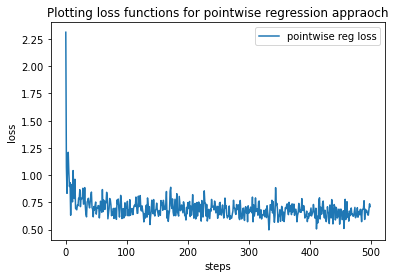

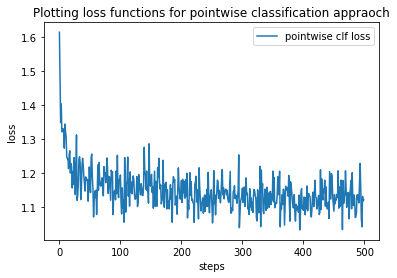

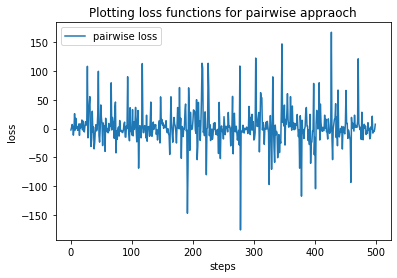

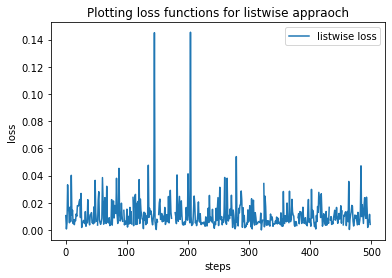

In [88]:
def autolabel(ax, rects, labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for l, rect in zip(labels, rects):
        height = rect.get_height()
        ax.annotate('{}'.format(l),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   fontsize=7)

def compare_methods(labels, metrics, metrics_to_plot={"ndcg", "precision@05", "recall@05"}):
    """
    Constructs bar plots to compare different methods. 
    
    labels: list/tuple of length N
    metrics: list/tuple of length N, containing dictionary containing the test set results 
    metrics_to_plot: set of metrics to plot - each metric creates a separate plot 
    """
    assert len(metrics) == len(labels)
    
    x = np.arange(len(metrics_to_plot)) 
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), sharey=False)
    fig.set_figheight(7)
    fig.set_figwidth(15)
    
    colors = cm.get_cmap("Set1").colors

    for metric, ax, c in zip(metrics_to_plot, axes, colors):
        m = [_[metric][0] for _ in metrics]  
        std = [_[metric][1] for _ in metrics]
        x = np.arange(len(labels))
        rects = ax.bar(x, m, label=metric, color=c)
        
        l = ["{0:.4f}({1:.4f})".format(_[metric][0], _[metric][1]) for _ in metrics]
        autolabel(ax, rects, l)
        
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticks(np.linspace(0, 1, num=11))
        ax.set_ylim(ymin=min(m) - 0.05, ymax= max(m) + 0.05)
        ax.set_title(metric)
    
    

def plot_distribution(labels, q_metrics, metric="ndcg"):
    """
    Plots the distribution of NDCG scores
    
    labels: list/tuple of length N
    q_metrics: list/tuple of dictionaries with length N, containing the query level results
    metric: the metric to plot
    
    """
    
    n = len(labels)
    # nC2
    n_plots = int((n*(n-1))/2)
    
    fig, axes = plt.subplots(nrows=n_plots, ncols=1)
    fig.set_figheight(8 * n_plots)
    fig.set_figwidth(10)
    
    colors = cm.get_cmap("Set1").colors
    
    for idx, (i, j) in enumerate(itertools.combinations(range(n), 2)):
        ax = axes[idx]
        
        im = q_metrics[i][metric]
        jm = q_metrics[j][metric]
        
        ax.hist(im, bins=50, label=labels[i], color=colors[i], alpha=0.55)
        ax.hist(jm, bins=50, label=labels[j], color=colors[j], alpha=0.55)
        
        ax.set_title(f"{labels[i]} vs {labels[j]}")
        ax.legend()
        ax.set_ylabel("Count")
        ax.set_xlabel("NDCG (binned)")

# plot loss for rate convergence discussion
pointwise_reg = np.load("pointwise_epoch_11_reg.npz")["loss"][:500]
pointwise_clf = np.load("pointwise_epoch_13_clf.npz")["loss"][:500]
pairwise_speedup = np.load("pairwise_epoch_8_speedup.npz")["loss"][:500]
listwise = np.load("listwise_epoch_8.npz")["loss"][:500]

plt.plot(range(len(pointwise_reg)), pointwise_reg, label = "pointwise reg loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Plotting loss functions for pointwise regression appraoch')
plt.legend()
plt.show()

plt.plot(range(len(pointwise_clf)), pointwise_clf, label = "pointwise clf loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Plotting loss functions for pointwise classification appraoch')
plt.legend()
plt.show()

plt.plot(range(len(pairwise_speedup)), pairwise_speedup, label = "pairwise loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Plotting loss functions for pairwise appraoch')
plt.legend()
plt.show()

plt.plot(range(len(listwise)), listwise, label = "listwise loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Plotting loss functions for listwise appraoch')
plt.legend()
plt.show()

In [90]:
# Load metrics and models

pointwise_regr_model = NeuralModule(1)
pointwise_regr_model.load_state_dict(torch.load("./pointwise_regr_wt"))

pointwise_clf_model = NeuralModule(5)
pointwise_clf_model.load_state_dict(torch.load("./pointwise_clf_wt"))
pointwise_clf_pred_fn = partial(clf_pred, net=pointwise_clf_model)

pairwise_model = NeuralModule(1)
pairwise_model.load_state_dict(torch.load("./pairwise_wt"))

listwise_model = NeuralModule(1)
listwise_model.load_state_dict(torch.load("./listwise_wt"))


methods = [
    {"results_file": "./pointwise_regression.json", "label": "Pointwise (R)"},
    {"results_file": "./pointwise_classification.json", "label": "Pointwise (C)"},
    {"results_file": "./pairwise.json", "label": "Pairwise"},
    {"results_file": "./listwise.json", "label": "Listwise"}
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])
    
    with open(m["results_file"]) as reader:
        r = json.load(reader)
    
    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])



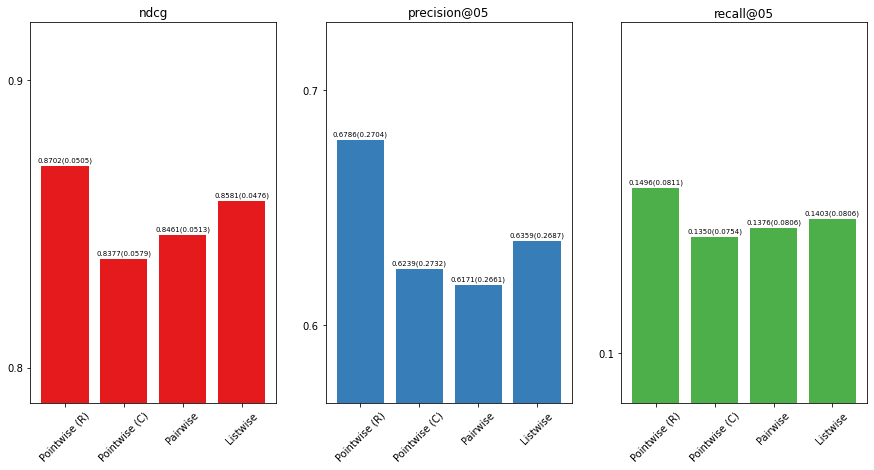

In [91]:
compare_methods(labels, results)

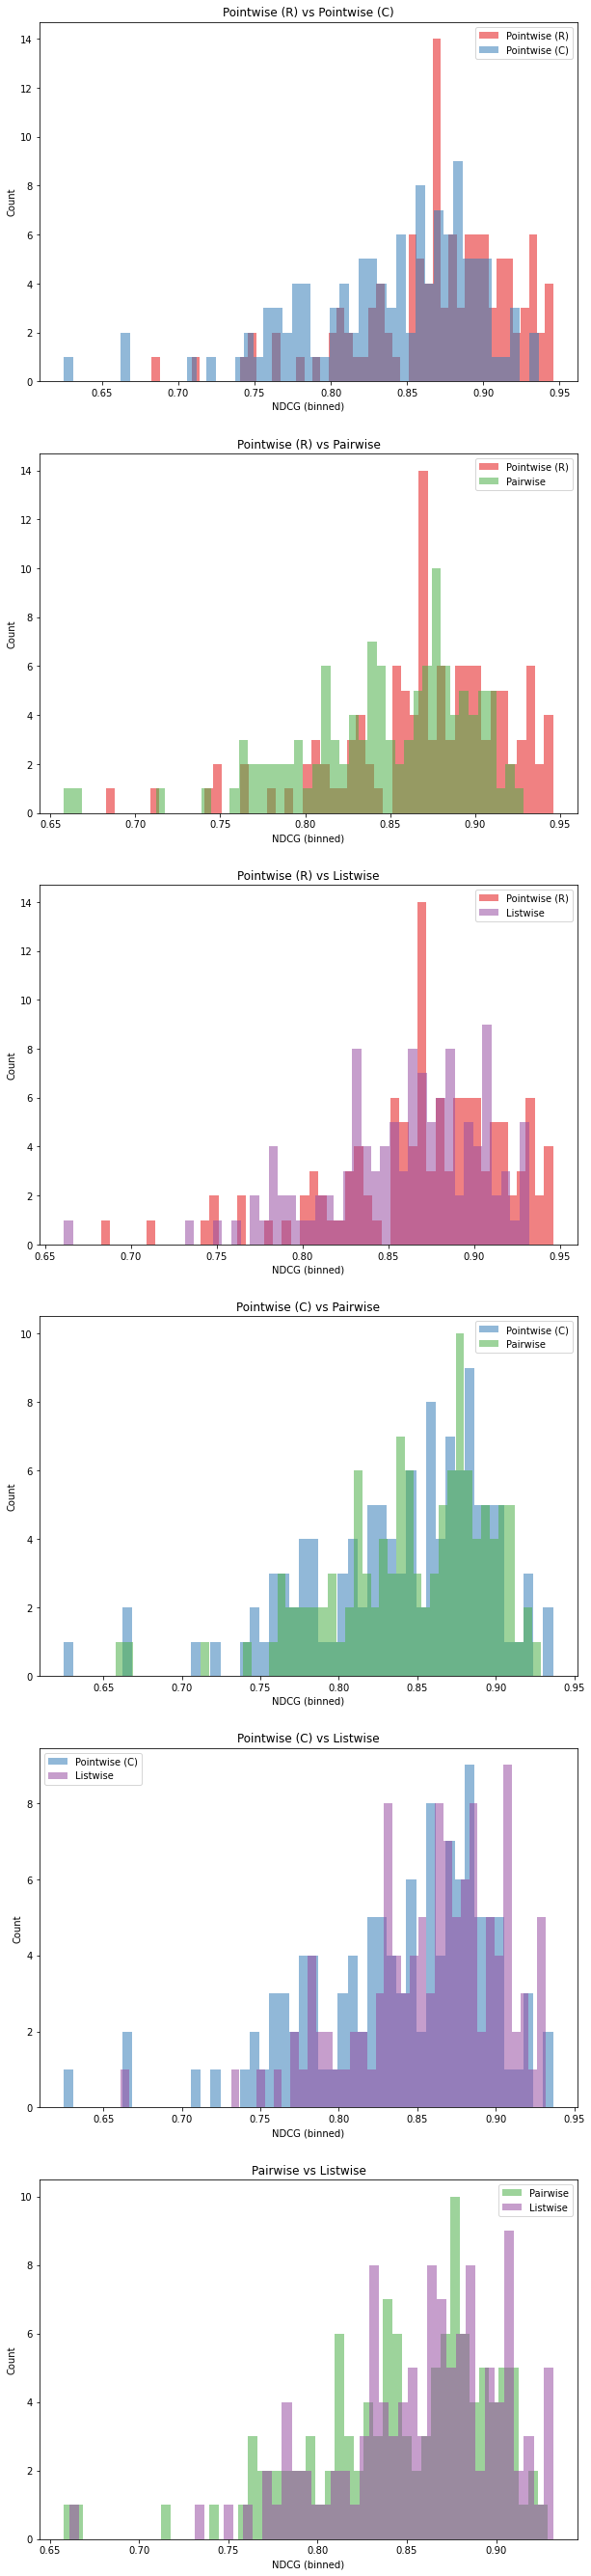

In [51]:
plot_distribution(labels, q_results)

In the next cell, report the performance metrics for the methods (25 points):



|     Model    | NDCG (s.d)| Precision@5 (s.d) | Recall@5 (s.d) |
|:------------:|:----------:|:-----------:|:--------:|
| Pointwise(R) |0.8717 (0.05077)|0.6803 (0.27557)|0.1508 (0.08320)|
| Pointwise(C) |0.8376 (0.05833)|0.6291 (0.28074)|0.1347 (0.07795)|
|   Pairwise   | 0.8531(0.05085)    |  0.6120(0.27337)  |   0.1323(0.07031) |
|   Listwise   |0.8542 (0.05141)|0.6154 (0.26169)|0.1367 (0.08033)|



**Rubric:** Each reported <Method, Metric> carries 2 points. 

YOUR ANSWER HERE

Write a conclusion in the next cell, considering (45 points):
- rates of convergence
- time complexity
- performance wrt the 3 metrics
- performance across queries
- ... any other observations

YOUR ANSWER HERE

Pointwise achieves higher NDCG, Precision@5 and Recall@5 than other methods while pairwise and listwise achieve similar performances. In terms of time complexity, despite of the complexity for running an ANN, pointwise is O(1), pairwise and listwise are O(n^2) and O(n) before the vectorization. After the vectorization, they all become O(1). As for the convergence rate, pointwise loss drops fast in the initial epoch then it converges very slowly, and pairwise loss converges more slowly than listwise loss, which means RankNet needs run more iterations in training than ListNet

From the distribution plots we can see that pointwise is more right tailed than pairwise appraoch, however the left tail is also distributed with really small ndcg. Pairwise and listwise both have dense center around 0.85-0.9. However pairwise seems to have more pairs achieveing this ndcg than listwise but at the same time it spans a broader area along the axis for ndcg than listwise method. What we can conclude from this is that pointwise tend to get more predictions with higher ndcg (right tailed) but it also has lots of predictions yield very low ndcg while for pariwise and listwise, their tails are more centered around the distribution without spanning very far from the central. This is intuitive and we will explain the mechnism in the following paragraph.

Pointwise approaches train a classifier or regressor on a single document for predicting the relevancy for the query.Then we arrange the results list to get final ranking for documents. The scores for each item in the query are all independent of other items in the list. Therefore the ranking structure is not taken into account, and the loss is a simple MSE instead of an IR metric directly. The time efficiency for this algorithm depends on the matrix multiplication behavior for ANN.  The convergence is fast where the error function drops fastly in the initial epoches before the convergence becomes very slow.

Pointwise appraoch achieves high NDCG (regression: around 87.17%, classification: around 83.76%) but the reason might be that our dataset is small thus it may overfit the data. To ensure this, we need to look at the behavior of variance across different epoches. Most importantly, we know that the objective function and the NDCG are not directly related in the training procedure and the way we rank documents, hence so we're unlikely to get reasonable NDCG results from this approach.

Pointwise achieves higher precision and recall comapred to other appraoches. As for precision@5, regression cases it achieves 0.6303 and recall@5 0.1508; classification case it achieves 0.6291 and 0.1347.  Precision is higher than recall which is expected as the ANN is built to take a single document and train a classifier or regressor on it to predict how relevant it is for the current query without caring much about whether irrelevant ones are also returned.

Pair-wise approaches analyze a pair of documents at a time in the loss function. They're trying to get the best order for a pair of documents compared to the ground truth. The aim of the ranker is to minimize the number of ranking inversions, or cases where a pair of results is wrongly ranked in relation to the ground truth. In practice, pairwise approaches are more effective than point approaches because they are better suited to estimating a relative location than to predict class labels. That is why we see in the distribution plot that pairwise approach is more centered and less spanned.

Listwise approach looking through the whole list of documents and developing the most optimal ordering with direct optimization of IR measure such as NDCG. 
The model should exhibit the same type of behaviour found in RankNet, although we do not see yet a notable improvement compared to other models, there is no significant gain with the use of the $|\bigtriangleup IRM (i,j)|$ in the final model calculation, which may be because of the low number of labels for each query.  In terms of time efficiency, as we need to consider the discounted gain for each of the swapped documents generated, with for loop it can be quite slow. However, if we use the vectorized form and perform matrix vector multiplication, the performance can be boosted. In terms of NDCG, it achives around 85.42% ndcg which is only slightly lower than pointwise regression model. The algorithms are trained on lambdaloss which is associated with NDCG directly, we also found that the NDCG values @k are better than other models as k increases. This is expected as k increases, we are trying to get the optimal ordering without getting too many irrelevant results compared to other models. In terms of precision and recall, Listwise has 0.6154 for precision and 0.1367 for recall. The algorithm look at the entire list of documents and try to come up with the optimal ordering for it. This is the desired behavior for ranking, as the user may put more importance on not getting the irrelevant results than make the relevant results more relevant. 

Pairwise model and Listwise model have lower precision and recall which is to be expected. The reason is as follows: The pairwise approach breaks a ranking into pairwise comparisons, while the pointwise approach keeps the ranks unchanged. This necessarily results in a lack of information for pairwise approach, even for complete set of comparisons. This is because the probability of observing the ranking as a whole differs from the probability of observing the set of pairwise preferences independently of one another statistically. One would wonder whether NN prediction as a function of item-features is meaningful. The pointwise method may yield unreliable or evening misleading results. The pairwise and listwise appraoches extract qualitative data although the information is less comprehensive, but it is still effective.

The results tend to favor Pointwise method (although measure of ndcg could be meaningless for this approach) if we look at k=1 for the evaluation metric considered NDCG; however as k inceases, the results tend to favor pairwise and listwise models as they train the model based on optimal ordering for pairs or lists. It is reasonable to have this kind of tradeoff because getting irrelevant results is less desired than improving the relevant ones to be more relevant. 

**References:**

Dandekar, Nikhil. “Pointwise vs. Pairwise vs. Listwise Learning to Rank.” Medium, Medium, 22 Mar. 2019, medium.com/@nikhilbd/pointwise-vs-pairwise-vs-listwise-learning-to-rank-80a8fe8fadfd.

Cao, Z., Qin, T., Liu, T. Y., Tsai, M. F., & Li, H. (2007, June). Learning to rank: from pairwise approach to listwise approach. In Proceedings of the 24th international conference on Machine learning (pp. 129-136).

# Chapter 2: Online LTR (180 points) <a class="anchor" id="onLTR"></a>

[Back to TOC](#top)

In this part we want to use user interactions for training learning to rank algorithms.
This part consists of the following sections:
 - Clicks Simulation (15 points)
 - Counterfactual Learning to Rank (80 points)
 - Online Evaluation (50 points)


## Section 1: Clicks Simulation (15 points) <a class="anchor" id="clicks"></a>

[Back to TOC](#top)

In online LTR, we work with user interactions such as clicks.
One way to test online LTR algorithms is to conduce semi-synthetic experiments.
In semi-synthetic experiments, the feature vectors of a LTR dataset (similar to what you used in Part 1) are used.
But instead of using the relevance labels for training the LTR algorithm, **simulated clicks** are used.

In this section we want to simulate clicks based on the labels and use the generated clicks in later sections to train our Counterfactual LTR (CLTR) algorithm.

First we need to have a *production ranker* that determines the order of documents for each query.
The click probability of each document depends on its rank in the results list as well as its relevance.

In [52]:
ranks = dataset.load_production_ranker()
print(f'ranks has {len(ranks.keys())} keys: {ranks.keys()}')
for key in ranks:
    print(f'{key} shape:{ranks[key].shape}')
    
data.train.ranks = ranks['train']
data.validation.ranks = ranks['valid']
data.test.ranks = ranks['test']

ranks has 3 keys: dict_keys(['train', 'valid', 'test'])
train shape:(85227,)
valid shape:(12794,)
test shape:(29881,)


**Implementation (5 points):**
Now use the `ranks` to generate clicks.
We assume documents with label $[3,4]$ are relevant and labels $[0,1,2]$ are non-relevant.
We also assume the examination probability of a document at rank $r$ is $\frac{1}{r}$.
Finally, we assume a $0.05$ noise.

This means that the click probability of a document with label $[3,4]$ at rank $r$ is $\frac{1}{r}$, while the click probability of a document with label $[0,1,2]$ at rank $r$ is $\frac{0.05}{r}$.

In [53]:
# TODO: Implement this! (5 points)
def generate_clicks(ranking, query_labels):
    """
    Generates random clicks based on the given list of ranking and relevance labels for the documents of one query.
    Input:
        ranking: contains the rank of documents, eg. ranking[5]=0 means that document 5 is shown at rank 0.
        query_labels: contains the labels of documents, eg. query_labels[5]=3 means that document 5 has a label equal to 3.
    Output:
        A np.array of clicked positions, eq. clicked=[1,4] meanse that documents at ranks 1 and 4 have been clicked. 
        Note that document at rank 1 may differ from document 1 (see description of ranking input).
        
    Hint: Use the np.random.binomial function for generating click from probability.
    """
    theta = 1. / np.arange(1, ranking.shape[0] + 1)
    noise_prob = 0.05 * theta
    # YOUR CODE HERE
    
    new_labels = [x for _, x in sorted(zip(ranking, labels))]

    for i, label in enumerate(new_labels):
        if label in [3, 4]:
            noise_prob[i] = theta[i]
            
    final = np.random.binomial(1, noise_prob)
    clicked = np.array(final.nonzero())[0]

    
#    raise NotImplementedError()
    return clicked.astype(np.int32)
 

In [54]:
ranking = np.array([2, 1, 3, 0, 4, 7, 5, 6])
labels = np.array([0, 3, 4, 1, 1, 2, 4, 3])

np.random.seed(4)
print(f'clicks: {generate_clicks(ranking, labels)}')
print('expected clicks for seed 4: [0 1 6]')



clicks: [0 1 6]
expected clicks for seed 4: [0 1 6]


**Implementation (10 points):**
Use `generate_clicks` to simulate clicks for different query sessions.
For this, randomly select a query id, generate random clicks on documents of that query using your `generate_clicks` implementation and only keep the clicks on `topk` positions (i.e. do not consider clicks on ranks after `topk` rank).
Repeat this process until you have `click_count` number of clicks.

In [55]:
# TODO: Implement this! (10 points)
def simulate_clicks(data, split_name, click_count, topk=20):
    """
    Simulate click_count clicks on topk results on the specified split of the data.
    Output:
        A list L=[L_0, L_1, ..., L_n] of lists. Each L_i is itself a list of clicks 
        over the documents of query number i, 
        eg. L_0=[0,2,0,1,0,5,2] means that in the sessions of the first query, 
        the documents at positions 0,1,2 and 5 were clicked 3,1,2 and 1 times, respectively.
    """
    data_split = getattr(data, split_name)
    num_queries = data_split.doclist_ranges.shape[0] - 1
    clicks = [[] for _ in range(num_queries)]
    np.random.seed(42)

    # YOUR CODE HERE

    argsorted = []
    ranked = []
    new_doclist_range = [0]

    for qid in range(data_split.doclist_ranges.shape[0] - 1):
        irank = np.argsort(data_split.ranks[data_split.doclist_ranges[qid]: data_split.doclist_ranges[qid+1]])
        shown_len = min(irank.shape[0], topk)
        argsorted.append(data_split.doclist_ranges[qid] + irank[:shown_len])
        new_doclist_range.append(shown_len)

    _argsorted = np.concatenate(argsorted, axis=0)
    _doclist_range = np.cumsum(np.array(new_doclist_range), axis=0)

    for i in range(click_count):
        qid = int(np.random.randint(0, num_queries, 1))
        s_i = _doclist_range[qid]
        e_i = _doclist_range[qid+1]

        lables = data_split.label_vector[s_i:e_i]
        rankings = data_split.ranks[s_i:e_i]

        clicks[qid] = np.append(clicks[qid], generate_clicks(rankings, lables)).astype(int)

        if len(np.concatenate(clicks, axis = 0)) >= click_count:
            break
    
    return clicks

    #raise NotImplementedError()

Use `simulate_clicks` function to simulate clicks for train and validation sets.

**Note:**
You can dump your generated clicks using pickle or numby and load them in your future runs to avoid long waiting times.

In [56]:
train_clicks = simulate_clicks(data,'train', click_count = 10000)

assert isinstance(train_clicks, list)
session_clicks = np.array(list(map(len, train_clicks)))
print(f'{session_clicks.sum()} clicks simulated over {session_clicks.shape[0]} queries.')
print(f'On average, each session has {session_clicks.mean()} clicks.')
print(f'min number of clicks per session:{session_clicks.min()}')
print(f'max number of clicks per session:{session_clicks.max()}')



10003 clicks simulated over 2735 queries.
On average, each session has 3.6574040219378428 clicks.
min number of clicks per session:0
max number of clicks per session:21


For our new click data, we need a new dataloader.
`QueryGroupedOnlineLTRData` provides what you will need for training an LTR model from the clicks:

In [57]:
class QueryGroupedOnlineLTRData(Dataset):
    def __init__(self, data, split, clicks, topk):
        self.split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert self.split is not None, "Invalid split!"
        self.clicks = clicks
        self.topk = topk
    
    def __len__(self):
        return self.split.num_queries()

    def __getitem__(self, q_i):
        s_i = self.split.doclist_ranges[q_i]
        e_i = self.split.doclist_ranges[q_i + 1]
        feature_ = self.split.feature_matrix[s_i:e_i,:]
        ranking = self.split.ranks[s_i:e_i]
        inverse_ranking = np.argsort(ranking)
#       We re-order the rows of feature matrix so that in coincides with the ranking of documents.
#       We also cut the documents after rank topk.
        feature = torch.FloatTensor(feature_[inverse_ranking[:self.topk],:])
        clicks = self.clicks[q_i]
        return q_i, feature, clicks
    
def qgo_collate_fn(batch):
    
    qids = []
    features = []
    clicks = []
    
    for (q, f, l) in batch:
        qids.append(q)
        features.append(f)
        clicks.append(l)
    return qids, features, clicks
    

## Section 2: Counterfactual LTR (90 points) <a class="anchor" id="cLTR"></a>

[Back to TOC](#top)

Now we want to use the simulated clicks and train a counterfactual LTR algorithm.
We will use a simple loss function:

$$
L=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} r(d, q) \cdot \lambda(\bar{rank}(d, D_q))
$$
where $Q$ is the set of queries, $D_q$ is the list of documents shown to the user for query $q$, $r(d, q)$ is the relevance of document $d$ to query $q$ and $rank(d, D_q)$ is the rank of $d$ in $D_q$.

In this assignment, we use sigmoid-like bound for $\lambda(\bar{rank}(d, D_q))$:

$$
\lambda(\bar{rank}(d, D_q)) = \sum_{d' \in D_q} log\left(
1+exp\left(-2\cdot(f(d)-f(d')\right)
\right)
$$


### Section 2.1. Biased LTR (20 points)

Remember that we do not have the explicit relevance in the online settings.
Instead, we have to learn from the clicks.
Clicks, implicitly indicate relevance.
A naive approach for learning from clicks would be to replace relevance with clicks and train a model with the loss function:

$$
L_{biased}=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} c(d, q) \cdot \lambda(\bar{rank}(d, D_q))
$$
where $c(d, q)$ indicates the number of times $d$ was clicked for query $q$.

In [58]:
# TODO: Implement this! (20 points)
def online_loss_biased(scores, clicks):
    """
    Compute and return the biased online loss *for a single query*. To compute this, use L_{biased} formula above.
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    clicks: list of clicked ranks. 
    
    Note: the scores are aligned with the click positions, i.e. scores[0] corresponds to the 0 rand, etc.
    
    """
    from collections import Counter
    click_counts = Counter(clicks)
    
    # YOUR CODE HERE
    
    diff = scores.T - scores
    rank = torch.sum(torch.log(1+ torch.exp(-2*(diff))), axis = 0)
    click = [click_counts[i] for i in range(len(scores))]

    loss = torch.dot(rank, torch.FloatTensor(click))
    
    return loss
    
    #raise NotImplementedError()

In [59]:
scores = torch.FloatTensor([1.2, -2, 1.1, 2.4, 0, 1.2])[:,None]
clicks = [0, 0, 1, 3, 1, 4, 0, 5, 0, 1, 2]
print(f'biased loss: {online_loss_biased(scores, clicks)}')
print(f'expected: 139.16246032714844')



biased loss: 139.16246032714844
expected: 139.16246032714844


### Section 2.2. Unbiased LTR (10 points)
Now modify `online_loss_biased` to debias the clicks, using IPS method:

$$
L_{unbiased}=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} \frac{c(d, q)}{P\left(o(d,q)=1\right)} \cdot \lambda(\bar{rank}(d, D_q))
$$
where $P\left(o(d,q)=1\right)$ indicates the probability that $d$ was observed by the user for query $q$.

In [60]:
# TODO: Implement this! (10 points)
def online_loss_unbiased(scores, clicks):
    """
    Compute and return the unbiased online loss *for a single query*. To compute this, use L_{unbiased} formula above.
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    clicks: list of clicked ranks. 
    
    Note 1: the scores are aligned with the click positions, i.e. scores[0] corresponds to the 0 rand, etc.
    Note 2: the weights are provided.
    
    """
    from collections import Counter
    click_counts = Counter(clicks)
    weights = torch.Tensor((1./np.arange(1,scores.shape[0]+1))[:,None])

    # YOUR CODE HERE
    
    diff = scores.T - scores
    rank = torch.sum(torch.log(1+ torch.exp(-2*(diff))), axis = 0)
    click = [click_counts[i] for i in range(len(scores))]
    weighted = torch.FloatTensor(click)/weights.T

    loss = torch.dot(rank, weighted[0])
        
    return loss

    #raise NotImplementedError()

In [3]:
import torch 
import numpy as np 

scores = torch.FloatTensor([1.2, -2, 1.1, 2.4, 0, 1.2])[:,None]
weights = torch.Tensor((1./np.arange(1,scores.shape[0]+1))[:,None])

In [5]:
np.arange(1,scores.shape[0]+1)

array([1, 2, 3, 4, 5, 6])

In [61]:
scores = torch.FloatTensor([1.2, -2, 1.1, 2.4, 0, 1.2])[:,None]
clicks = [0, 0, 1, 3, 1, 4, 0, 5, 0, 1, 2]
print(f'biased loss: {online_loss_unbiased(scores, clicks)}')
print(f'expected: 323.68145751953125')


biased loss: 323.6814270019531
expected: 323.68145751953125


**Implementation (60 points):**
In the next cell, write a wrapper that uses your loss functions and simulated clicks to train an online LTR method (no evaluation on validation set is required):

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected for biased loss: 15 points
 - Performance as expected for unbiased loss: 15 points

In [62]:
# TODO: Implement this! (60 points)
def train_online(net, train_clicks, loss_fn, params):
    """
    Use QueryGroupedOnlineLTRData to load the data train split and clicks.
    Use the appropriate loss_fn (biased/unbiased).
    No need to use validation set.
    """
    # YOUR CODE HERE
    
    epochs = params.epochs
    lr = params.lr
    topk = params.topk
    
    data_split = QueryGroupedOnlineLTRData(data, 'train', train_clicks, topk)
    query_num = data_split.__len__()
    optimizer = Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        
        for qid in range(query_num):

            q_i, feature, clicks = data_split.__getitem__(qid)

            optimizer.zero_grad()
            scores = net(feature)
            loss = loss_fn(scores, clicks) 
            loss.backward() 
            optimizer.step()

    # raise NotImplementedError()


In [63]:
params = Namespace(epochs=3, lr=1e-3, topk=20)
train_clicks = simulate_clicks(data,'train', click_count = 50000)
biased_net = NeuralModule(1)
train_online(biased_net, train_clicks, online_loss_biased, params)
unbiased_net = NeuralModule(1)
train_online(unbiased_net, train_clicks, online_loss_unbiased, params)

In [64]:
evaluate_model(biased_net, 'test', print_results=True)
evaluate_model(unbiased_net, 'test', print_results=True)


"metric": "mean" ("standard deviation")
dcg: 90.7135 (19.02588)
dcg@03: 5.0043 (3.20915)
dcg@05: 7.1012 (3.62327)
dcg@10: 11.3519 (4.63820)
dcg@20: 17.7242 (5.88092)
ndcg: 0.7027 (0.04684)
ndcg@03: 0.1808 (0.13310)
ndcg@05: 0.1949 (0.11549)
ndcg@10: 0.2269 (0.10309)
ndcg@20: 0.2667 (0.09235)
precision@01: 0.1111 (0.31427)
precision@03: 0.1111 (0.20441)
precision@05: 0.1162 (0.16170)
precision@10: 0.1299 (0.13604)
precision@20: 0.1316 (0.10734)
recall@01: 0.0053 (0.01900)
recall@03: 0.0145 (0.02953)
recall@05: 0.0258 (0.04217)
recall@10: 0.0535 (0.06085)
recall@20: 0.1039 (0.08109)
relevant rank: 117.2860 (76.69519)
relevant rank per query: 3018.3590 (1457.25306)


/Users/willchien/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


"metric": "mean" ("standard deviation")
dcg: 93.6550 (20.02720)
dcg@03: 7.0373 (5.08079)
dcg@05: 9.3056 (5.68508)
dcg@10: 14.0368 (6.87846)
dcg@20: 20.8811 (7.89625)
ndcg: 0.7252 (0.05386)
ndcg@03: 0.2502 (0.18191)
ndcg@05: 0.2524 (0.15441)
ndcg@10: 0.2789 (0.13938)
ndcg@20: 0.3131 (0.11405)
precision@01: 0.1966 (0.39741)
precision@03: 0.2222 (0.26510)
precision@05: 0.1949 (0.21477)
precision@10: 0.1855 (0.16909)
precision@20: 0.1697 (0.12212)
recall@01: 0.0085 (0.02000)
recall@03: 0.0263 (0.03422)
recall@05: 0.0382 (0.04136)
recall@10: 0.0761 (0.07448)
recall@20: 0.1359 (0.08951)
relevant rank: 101.6792 (69.25750)
relevant rank per query: 2616.7179 (1301.09902)


{'dcg': (93.6550109074931, 20.027204682341846),
 'dcg@03': (7.037261254243083, 5.080786278779034),
 'dcg@05': (9.305554224065368, 5.685077752447881),
 'dcg@10': (14.036818067272517, 6.878463348586608),
 'dcg@20': (20.881114023468317, 7.89625280012747),
 'ndcg': (0.7251719537636798, 0.053858661383755925),
 'ndcg@03': (0.2501942083448543, 0.18190845752631735),
 'ndcg@05': (0.25239453361886866, 0.15440507208414264),
 'ndcg@10': (0.27890717641180923, 0.1393775963991367),
 'ndcg@20': (0.31309735782131853, 0.11404591140862969),
 'precision@01': (0.19658119658119658, 0.3974129209423135),
 'precision@03': (0.2222222222222222, 0.2650950840900995),
 'precision@05': (0.19487179487179487, 0.2147732470909941),
 'precision@10': (0.18547008547008548, 0.16909257933798333),
 'precision@20': (0.16965811965811967, 0.1221175811693482),
 'recall@01': (0.008524161771336764, 0.020004875896278168),
 'recall@03': (0.02629834962924981, 0.034218737681635),
 'recall@05': (0.038225122367284814, 0.04136049407821138

In [65]:
seed(42)
train_clicks = simulate_clicks(data,'train', click_count = 50000)
params = Namespace(epochs=3, 
                    lr=1e-3,
                    batch_size=1,
                    topk=20,
                    metrics={"ndcg", "precision@05", "recall@05"})
biased_model = NeuralModule(1)

create_results(biased_model, 
               train_online, 
               biased_model,
               "./biased_model.json",
               train_clicks,
               online_loss_biased,
               params)
# persist model
torch.save(biased_model.state_dict(), "./biased_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 89.7429 (18.91951)
dcg@03: 4.6289 (3.00785)
dcg@05: 6.4898 (3.41169)
dcg@10: 10.0338 (4.24221)
dcg@20: 16.3014 (6.06175)
ndcg: 0.6952 (0.05034)
ndcg@03: 0.1693 (0.12614)
ndcg@05: 0.1798 (0.11100)
ndcg@10: 0.2023 (0.09697)
ndcg@20: 0.2464 (0.09328)
precision@01: 0.0940 (0.29185)
precision@03: 0.0883 (0.18176)
precision@05: 0.0889 (0.14663)
precision@10: 0.0880 (0.12415)
precision@20: 0.1115 (0.11311)
recall@01: 0.0029 (0.00956)
recall@03: 0.0106 (0.02439)
recall@05: 0.0169 (0.03030)
recall@10: 0.0312 (0.03912)
recall@20: 0.0841 (0.07660)
relevant rank: 115.9107 (71.36259)
relevant rank per query: 2982.9658 (1393.01424)


In [66]:
seed(42)

params = Namespace(epochs=3, 
                    lr=1e-3,
                    batch_size=1,
                    topk=20,
                    metrics={"ndcg", "precision@05", "recall@05"})
unbiased_model = NeuralModule(1)

create_results(unbiased_model, 
               train_online, 
               unbiased_model,
               "./unbiased_model.json",
               train_clicks,
               online_loss_unbiased,
               params)
# persist model
torch.save(biased_model.state_dict(), "./unbiased_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 91.6928 (19.74776)
dcg@03: 5.1263 (3.93460)
dcg@05: 7.3710 (4.32233)
dcg@10: 11.6986 (5.27062)
dcg@20: 18.3784 (6.76255)
ndcg: 0.7095 (0.05038)
ndcg@03: 0.1818 (0.14786)
ndcg@05: 0.1996 (0.12218)
ndcg@10: 0.2321 (0.10893)
ndcg@20: 0.2745 (0.09512)
precision@01: 0.1197 (0.32456)
precision@03: 0.1481 (0.21984)
precision@05: 0.1641 (0.17661)
precision@10: 0.1650 (0.14578)
precision@20: 0.1521 (0.11024)
recall@01: 0.0046 (0.01376)
recall@03: 0.0167 (0.02604)
recall@05: 0.0334 (0.03803)
recall@10: 0.0656 (0.05536)
recall@20: 0.1218 (0.08082)
relevant rank: 104.2700 (69.43671)
relevant rank per query: 2683.3932 (1321.57979)


In [68]:
# YOUR CODE HERE
# raise NotImplementedError()

### Section 2.3: Comparison (20 points)

Now we can compare two loss functions: biased and unbiased.
We want to see how they can improve by increasing the number of training clicks.
Train both biased and unbaised models on $[2000, 10000, 50000]$ number of clicks and compare the results.

Plot the results in a **single** figure with x-axis showing the number of trainin clicks and y-axis showing the nDCG@10.
Discuss your observations.


**Rubric:**
- Two curves are plotted in the figure: 10 points
- Clear titles, x label, y labels and legends (if applicable): 5 points
- Explain what you observe: 5 points

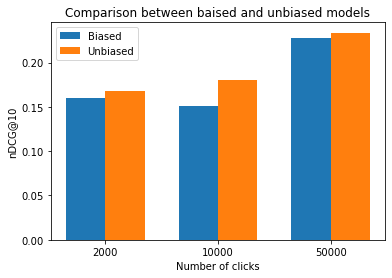

In [69]:
# YOUR CODE HERE
seed(42)

biased_result = []
unbiased_result = []

clicks_test = [2000, 10000, 50000]

for click in clicks_test:
    
    train_clicks = simulate_clicks(data,'train', click_count = click)
    params = Namespace(epochs=3, 
                       lr=1e-3,
                       batch_size=1,
                       topk=20)
    
    biased_model = NeuralModule(1)
    unbiased_model = NeuralModule(1)
    
    train_online(biased_model, train_clicks, online_loss_biased, params)
    train_online(unbiased_model, train_clicks, online_loss_unbiased, params)
    
    biased_metrics, biased_qq = evaluate_model(biased_model, "test", print_results=False, q_level=True)
    unbiased_metrics, unbiased_qq = evaluate_model(unbiased_model, "test", print_results=False, q_level=True)
    
    biased_result.append(biased_metrics['ndcg@10'][0])
    unbiased_result.append(unbiased_metrics['ndcg@10'][0])
    
x = np.arange(len(clicks_test)) 
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, biased_result, width, label='Biased')
rects2 = ax.bar(x + width/2, unbiased_result, width, label='Unbiased')

ax.set_ylabel('nDCG@10')
ax.set_xlabel('Number of clicks')
ax.set_title('Comparison between baised and unbiased models')
ax.set_xticks(x)
ax.set_xticklabels(clicks_test)
ax.legend()

# raise NotImplementedError()

# Observation:
# In general, the nDCG@10 scores are higher in all three unbiased models than 
# their biased counterparts. After increasing the clicks simulation from 2000 
# to 50000, we can observe a remarkable growth in the metrics in the unbiased model. 
# However, although a similar increase in metric can be noted from 2000 clicks to 50000 
# clicks in the biased model, we can see a small drop instead when it inclines from 2000 
# to 10000 clicks. 

## Section 3: Online Evaluation (75 points) <a class="anchor" id="on_eval"></a>

[Back to TOC](#top)

Sometimes, in online search engines, we want to compare two or more different ranking functions based on the user interactions.
This comparison is done via online evaluation.

In this section we implement one of the online evaluation methods: probabilistic multileaving.

We compare three rankers:
 - Production ranker: the ranks that are provided to you for doing the click simulation.
 - Biased method from previous section.
 - Unbiased method from previous section

Before proceeding, we need some auxiliary functions:

 - `invert_ranking` gets the ranking and gives the inverted rankings. This means that for an input with `rank[d]=r`, the output would be `i_rank[r]=d`.


 - `get_predictions` gives a dictionary of predictions, i.e. `predictions[qid]` is the list of scores produced by the given model.


In [70]:
def get_predictions(net, test_clicks, topk):
    test_dl = DataLoader(QueryGroupedOnlineLTRData(data, 'test', test_clicks, topk), 
                          batch_size=1, 
                          shuffle=False,
                          collate_fn=qg_collate_fn)
    predictions = {}
    for qids, x, _ in test_dl:
        predictions[qids[0]] = net(x[0]).detach().numpy()[:,0]
    return predictions


def invert_rankings(rankings):
    '''
    Invert indices in a matrix of rankings, ranking per row.
    '''
    inverted = np.zeros(rankings.shape)
    
    inverted[np.arange(rankings.shape[0])[:,None],rankings] = np.arange(rankings.shape[1])[None,:]
    return inverted


The next cell helps you build the ranking matrix for each query in the test set.
The first row is the production ranker, the second row is the biased ranker and the third row is the unbiased ranker.

In [71]:
# we only need the ranking of the production ranker for the test set. No clicks have to be simulated here.
test_clicks = simulate_clicks(data, 'test', click_count = 0)
biased_predictions = get_predictions(biased_net, test_clicks, 20)
unbiased_prediction = get_predictions(unbiased_net, test_clicks, 20)

def get_ranking_matrix(qid, topk):
    ranking_matrix = np.empty([3, min(data.test.query_size(qid), topk)], dtype=np.int32)
    ranking = data.test.ranks[data.test.doclist_ranges[qid]:data.test.doclist_ranges[qid+1]]
    ranking_matrix[0,:] = np.arange(ranking_matrix.shape[1])
    ranking_matrix[1,:] = np.argsort(-biased_predictions[qid])
    ranking_matrix[2,:] = np.argsort(-unbiased_prediction[qid])
    return ranking_matrix

In [72]:
print(get_ranking_matrix(0, 20))

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 1 18 19  2  6  0 10  4 14  7  9 16 17  8  3 15  5 11 13 12]
 [ 3 16  6  1  4 18  8 14  5 13 12  9  2  0 19 10  7 11 15 17]]


### Section 3.1 Multileaving (10 points)

Given the rankings of multiple rankers, we want to decide how to fill the results list and show it to the users.
Implement the following function.

In [73]:
# TODO: Implement this! (10 points)
def sample(ranking):
    numerators = 1.0 / np.array(range(1, len(ranking)+1)) ** 3 #tau =3 
    denominator = sum(numerators)
    
    non_zero_index = set(range(len(numerators)))
    p = np.random.rand() * denominator

    cum = 0.0
    for i in non_zero_index:
        cum += numerators[i]
        if cum > p:
            return ranking[i]
        
    return ranking[i]

def make_multileaving(inverted_rankings, topk):
    '''
    ARGS: (all np.array of docids)
    - inverted_rankings: matrix (rankers x documents) where [x,y] corresponds to the rank of doc y in ranker x
    RETURNS
    - ranking of indices corresponding to inverted_rankings
    '''
    n_rankers = inverted_rankings.shape[0]
    n = inverted_rankings.shape[1]
    k = min(n, topk)

    # YOUR CODE HERE
    
    rankers = dict([[i, ranker] for i, ranker in enumerate(inverted_rankings)])
    result  = []

    for n in range(k):
        ranker_idx = int(np.random.randint(0, n_rankers, 1))

        this_ranker = rankers[ranker_idx]
        docid = sample(this_ranker)
        result.append(docid)

        for i, ranker in rankers.items():
            if docid in ranker:
                new_ranker = ranker[ranker != docid]
                rankers[i] = new_ranker
                
    return np.array(result)
    
    # raise NotImplementedError()

In [74]:
print(make_multileaving(invert_rankings(get_ranking_matrix(0, 20)), 20))

[13.  3.  0.  5. 12.  1.  4. 14.  7.  2. 16.  6.  8. 11. 15. 18.  9. 17.
 10. 19.]


In [75]:
# YOUR CODE HERE
# raise NotImplementedError()

### Section 3.2: Probability of rankers (15 points)

We have shown the multileaved list to the user and they clicked on some documents.
In this function we want to calculate the probability that the clicked documents belong to a specific ranker.

Note that the results of rankers are not unique and each document in the results list may belong to different rankers.
So we need to assign a *probability* to each click belonging to each ranker.

In [76]:
# TODO: Implement this! (15 points)
def probability_of_list(result_list, inverted_rankings, clicked_docs):
    '''
    ARGS: (all np.array of docids)
    - result_list: the multileaved list
    - inverted_rankings: matrix (rankers x documents) where [x,y] corresponds to the rank of doc y in ranker x
    - clicked_docs: boolean array of result_list length indicating clicks
    RETURNS
    -sigmas: matrix (rankers x clicked_docs) with probabilty ranker added clicked doc
    '''
    n_docs = inverted_rankings.shape[1]
    n_rankers = inverted_rankings.shape[0]

    # click_doc_ind = result_list[clicked_docs] this one is revised 
    click_doc_ind = [result_list[i] for i in clicked_docs]

    # YOUR CODE HERE
    
    sigmas = []

    for rank_i in range(n_rankers):
        
        this_ranker = inverted_rankings[rank_i]
        numerators = 1.0 / np.array(range(1, len(this_ranker)+1)) ** 3 #tau =3 
        denominator = sum(numerators)

        temp = []
        for indice in click_doc_ind:
            if indice in this_ranker:
                inverse_rank_d = 1/(np.where(this_ranker == indice)[0] +1) ** 3
            else:
                inverse_rank_d = 0
                
            temp.append(inverse_rank_d/denominator)

        sigmas.append(temp)

    return np.array(sigmas).T[0]
    
    #raise NotImplementedError()

In [77]:
ranking_matrix = get_ranking_matrix(0, 20)
result_list = make_multileaving(invert_rankings(ranking_matrix), 20)
clicks = [0,4,9,10]
probabilities = probability_of_list(result_list, invert_rankings(ranking_matrix), clicks)
print(f'ranking matrix:\n {ranking_matrix}')
print(f'results list (shown to user):\n {result_list}')
print(f'clicked documents: {clicks}')
print(f'probabilities:\n {probabilities}')

ranking matrix:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [ 1 18 19  2  6  0 10  4 14  7  9 16 17  8  3 15  5 11 13 12]
 [ 3 16  6  1  4 18  8 14  5 13 12  9  2  0 19 10  7 11 15 17]]
results list (shown to user):
 [ 5.  0. 13.  2. 12.  3. 14.  7. 16.  4.  9. 10.  8.  6. 17.  1. 11. 15.
 18. 19.]
clicked documents: [0, 4, 9, 10]
probabilities:
 [[3.85523658e-03 8.32731101e-01 1.21407071e-04]
 [3.79030997e-04 1.42786540e-04 3.08418926e-02]
 [6.66184881e-03 2.42778747e-03 6.66184881e-03]
 [8.32731101e-04 1.62642793e-03 3.03473433e-04]]


In [78]:
# YOUR CODE HERE
# raise NotImplementedError()

### Section 3.3: Preference matrix (10 points)

Given the probabilities of each ranker being clicked, we want to calculate a preference matrix that for each pair of rankers tells us which one is preferred by the clicks.

In [79]:
# TODO: Implement this! (10 points)
def preferences_of_list(probs):
    '''
    ARGS:
    -probs: clicked docs x rankers matrix with probabilities ranker added clicked doc  (use probability_of_list)
    -n_samples: number of samples to base preference matrix on
    RETURNS:
    - preference matrix: matrix (rankers x rankers) in this matrix 
    [x,y] > 0 means x won over y and [x,y] < 0 means x lost from y
      the value is analogous to the (average) degree of preference
    '''
    n_samples = 10
    n_clicks = probs.shape[0]
    n_rankers = probs.shape[1]
    
    # YOUR CODE HERE
    
    infer_matrix = np.zeros((n_rankers, n_rankers))
    ranker_sum = probs.sum(axis = 0)
    infer_matrix = ranker_sum.reshape(n_rankers,1) - ranker_sum
            
    return infer_matrix

    #raise NotImplementedError()

def infer_preferences(inverted_rankings, result_list, clicked_docs):
    n_rankers = inverted_rankings.shape[0]
    if np.any(clicked_docs):
        return preferences_of_list(probability_of_list(result_list,
                                        inverted_rankings,
                                        clicked_docs))
    else:
        return np.zeros((n_rankers, n_rankers))

In [8]:
dic = {1: 12, 2:6, 3: 8}


In [9]:
dic.sort_

AttributeError: 'dict' object has no attribute 'sort'

In [80]:
print(preferences_of_list(probabilities))

[[ 0.         -0.82519926 -0.02619977]
 [ 0.82519926  0.          0.79899948]
 [ 0.02619977 -0.79899948  0.        ]]


In [81]:
# YOUR CODE HERE
#raise NotImplementedError()

Now we can simulate the multileaving to see how our target rankers are evaluated by it.

In [82]:
def simulate_multileaving(n_impressions, topk):
    n_samples = 10
    impressions = 0
    pref_update = 0
    total_pref = np.zeros((3, 3))
    for step_i in range(n_impressions):
        qid = np.random.randint(0, data.test.doclist_ranges.shape[0] - 1)

        start_i = data.test.doclist_ranges[qid]
        end_i = data.test.doclist_ranges[qid + 1]
        n_query_docs = end_i - start_i
        query_labels = data.test.label_vector[start_i:end_i]

        inverted_rankings = invert_rankings(get_ranking_matrix(qid, topk))
        multileaving = make_multileaving(inverted_rankings, topk)

        cur_clicks = generate_clicks(multileaving, query_labels)

        if np.any(cur_clicks):
            pref = infer_preferences(inverted_rankings, multileaving, cur_clicks)
            total_pref += pref
            pref_update += 1
    return total_pref / pref_update


In [83]:
simulate_multileaving(10000, 20)

array([[ 0.        , -0.13920596, -0.13108121],
       [ 0.13920596,  0.        ,  0.00812475],
       [ 0.13108121, -0.00812475,  0.        ]])

### Section 3.4: Analysis (40 points)

Analyze the behavior of your multileaving implementation by testing it with two different `topk` values: $[5,20]$ and with different number of evaluation clicks: $[2000, 10000, 50000]$.

Put the preference of the unbiased method over the biased method (i.e. `pref[2,1]` in the matrix output of `simulate_multileaving` function) for these experiments in a table.

**Rubric:**
- Six experiments: 12 points
- Analysis of the observations: 28 points

In [93]:
# YOUR CODE HERE

# update with the customed function

biased_predictions_5 = get_predictions(biased_net, test_clicks, 5)
unbiased_prediction_5 = get_predictions(unbiased_net, test_clicks, 5)
biased_predictions_20 = get_predictions(biased_net, test_clicks, 20)
unbiased_prediction_20 = get_predictions(unbiased_net, test_clicks, 20)

def custom_get_ranking_matrix_5(qid, topk):

    ranking_matrix = np.empty([3, min(data.test.query_size(qid), topk)], dtype=np.int32)
    ranking = data.test.ranks[data.test.doclist_ranges[qid]:data.test.doclist_ranges[qid+1]]
    ranking_matrix[0,:] = np.arange(ranking_matrix.shape[1])
    ranking_matrix[1,:] = np.argsort(-biased_predictions_5[qid])
    ranking_matrix[2,:] = np.argsort(-unbiased_prediction_5[qid])

    return ranking_matrix

def custom_get_ranking_matrix_20(qid, topk):

    ranking_matrix = np.empty([3, min(data.test.query_size(qid), topk)], dtype=np.int32)
    ranking = data.test.ranks[data.test.doclist_ranges[qid]:data.test.doclist_ranges[qid+1]]
    ranking_matrix[0,:] = np.arange(ranking_matrix.shape[1])
    ranking_matrix[1,:] = np.argsort(-biased_predictions_20[qid])
    ranking_matrix[2,:] = np.argsort(-unbiased_prediction_20[qid])

    return ranking_matrix

def cust_simulate_multileaving(impressions_list, topk, get_ranking_matrix_fn):
    n_samples = 10 # what's this for?
    impressions = 0
    pref_update = 0
    total_pref = np.zeros((3, 3))
    result = []
    
    for step_i in range(impressions_list[2]):
        qid = np.random.randint(0, data.test.doclist_ranges.shape[0] - 1)

        start_i = data.test.doclist_ranges[qid]
        end_i = data.test.doclist_ranges[qid + 1]
        n_query_docs = end_i - start_i
        query_labels = data.test.label_vector[start_i:end_i]

        inverted_rankings = invert_rankings(get_ranking_matrix_fn(qid, topk))
        multileaving = make_multileaving(inverted_rankings, topk)

        cur_clicks = generate_clicks(multileaving, query_labels)

        if np.any(cur_clicks):
            pref = infer_preferences(inverted_rankings, multileaving, cur_clicks)
            total_pref += pref
            pref_update += 1
            
        if step_i == impressions_list[0]-1:
            result.append(total_pref / pref_update)
            
        elif step_i == impressions_list[1]-1:
            result.append(total_pref / pref_update)
            
        elif step_i == impressions_list[2]-1:
            result.append(total_pref / pref_update)
            
        else:
            continue 
            
    return result

eval_clicks = [2000, 10000, 50000]
result_5 = cust_simulate_multileaving(eval_clicks, 5, custom_get_ranking_matrix_5)
result_20 = cust_simulate_multileaving(eval_clicks, 20, custom_get_ranking_matrix_20)
result = [[i[2][1],j[2][1]] for i, j in zip(result_5, result_20)]
df = pd.DataFrame(result)
df = df.rename(columns={0: "Topk=5", 1: "Topk=20"})
df["Clicks"] = eval_clicks
df

#raise NotImplementedError()

# Observation:
# In general, we can notice that unbiased methods are generally favored over biased 
# methods in most of the experiments. Except for one setting (Topk=20, Clicks =2000)
# the rest of the experiments show a positive result at [2,1] across the preference matrix. 

# However, when the number of clicks simulation increase, the difference between unbiased 
# and baised rankers become less noticeable. For example, in the setting of topk =5, the 
# gap of preference value drops from 0.064679 to 0.007647 while clicks grow from 2000 to 
# 50000. Similarly, the same phenomenon can be seen when a larger topk value is applied. 
# When clicks are set to 10000, the gap of two rankers' preference shrinks in value.

# To wrap up, although unbiased rankers seem to be favored across six experiments, 
# unbaised models tend to be more favorable in a conversative setting with less clicks 
# or smaller topk value. 

,Topk=5,Topk=20,Clicks
0,0.064679,-0.016489,2000
1,0.014867,0.007513,10000
2,0.007647,0.003306,50000
